<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DSI 37 Capstone Project

<a id='part_iii'></a>
[Part I](Part_1-Data_Collection.ipynb#part_i) <br>
[Part II](Part_2-Prepare_Training_Data.ipynb#part_ii)

# Part III: EDA and Modeling
This section comprises the final part (Part 3 of 3) of the project code, encompassing both Exploratory Data Analysis and Modeling stages.

<a id='part_iii'></a>

## Contents

[1. Glossary](#glossary)<br>
[2. Import Libraries](#import)<br>
[3. Load Datasets](#load_datasets)<br>
[4. EDA](#eda)<br>
[5. Feature Engineering](#feature_engineering)<br>
[6. Modeling](#modeling)<br>
[7. Insights](#insights)<br>
[8. Business Recommendations](#biz_rec)<br>
[9. Conclusion](#conclusion)<br>

<a id='glossary'></a>

## 1. Glossary

### Data Dictionary
The data dictionary for the 2 datasets utilized in this section is provided below for reference.

`train_df`
post_comment	id	sentence	entity	pos_sentiment_words	neg_sentiment_words	textblob	sentiment
|Feature|Type|Description|
|:---|:---:|:---|
|<b>post_comment</b>|*object*|Whether this sentence is from post or comment|
|<b>id</b>|*object*|Id of the TikTok post with indication of whether the sentence is from a post or comment|
|<b>sentence</b>|*object*|Sentence text|
|<b>entity</b>| *object*|Entities found in the sentence|
|<b>pos_sentiment_words</b>|*object*|Words found in the sentence with positive sentiment|
|<b>neg_sentiment_words</b>|*object*|Words found in the sentence with negative sentiment|
|<b>textblob</b>|*float64*|Sentiment score ranging from -1 to 1|
|<b>sentiment</b>|*float64*|Adjusted sentiment score ranging from 0 to 10|

<br>

`sg_entities_patterns_df`

|Feature|Type|Description|
|:---|:---:|:---|
|<b>label</b>|*object*|Label of the tourist attraction (entity)|
|<b>pattern</b>|*object*|Pattern to recognize as tourist attraction (entity)|
|<b>sublocation</b>|*object*|Actual name of the tourist attraction (entity)|
|<b>interest_1</b>| *object*|Main category in which the tourist attraction falls under|
|<b>interest_2</b>|*object*|Secondary category in which the tourist attraction falls under|
|<b>indoor_outdoor</b>|*object*|Whether the tourist attraction is indoors or outdoors|

<br>

<a id='import'></a>

## 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import skew, shapiro

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb

from sklearn.metrics import r2_score, mean_squared_error

import pickle

In [2]:
from keras.preprocessing.text import Tokenizer # clean and tokenize data
from keras.preprocessing.sequence import pad_sequences #
from keras.initializers import he_normal
import tensorflow as tf
import keras.backend as K # facilitate the computation of performance metrics

<a id='load_datasets'></a>

## 3. Load Datasets

In [173]:
train_df = pd.read_csv('../datasets/train_df.csv')
sg_entities_patterns_df = pd.read_csv('../datasets/sg_entities_patterns.csv')

#### Check each dataset

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31327 entries, 0 to 31326
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   post_comment         31327 non-null  object 
 1   id                   31327 non-null  object 
 2   sentence             31327 non-null  object 
 3   entity               31327 non-null  object 
 4   pos_sentiment_words  31327 non-null  object 
 5   neg_sentiment_words  31327 non-null  object 
 6   textblob             31327 non-null  float64
 7   sentiment            31327 non-null  float64
dtypes: float64(2), object(6)
memory usage: 1.9+ MB


In [174]:
sg_entities_patterns_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           510 non-null    object
 1   pattern         510 non-null    object
 2   sublocation     510 non-null    object
 3   interest_1      510 non-null    object
 4   interest_2      74 non-null     object
 5   indoor_outdoor  510 non-null    object
dtypes: object(6)
memory usage: 24.0+ KB


In [8]:
train_df.head()

,post_comment,id,sentence,entity,pos_sentiment_words,neg_sentiment_words,textblob,sentiment
0,post,0_post,how to spend the perfect 48 hours in singapore,"['48 hour', 'singapore']",['perfect'],[],1.000000,10.000000
1,post,0_post,first head to your waterfall at singapore airp...,"['first', 'singapore airport']","['absolutely', 'incredible']",[],0.900000,9.642857
2,post,0_post,then head to the center and drop by the future...,"['future world exhibition', 'art science museum']",[],[],0.000000,6.428571
3,post,0_post,next you have to head to gardens by the bay it...,['garden by the bay'],"['completely', 'free', 'amazing']",[],0.333333,7.619048
4,post,0_post,dont forget to buy tickets for the skyway for ...,"['skyway', 'floral fantasy']","['most', 'magical']",['insane'],0.000000,6.428571


In [9]:
sg_entities_patterns_df.head()

,label,pattern,sublocation,count,country,interest_1,interest_2,indoor_outdoor,adjective,video_sentiment,comment_sentiment
0,FAC,100 am,100 am,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN
1,FAC,313,313 somerset,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN
2,FAC,313 somerset,313 somerset,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN
3,FAC,321 clementi,321 clementi,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN
4,FAC,888 plaza,888 plaza,NaN,NaN,shopping,NaN,indoor,NaN,NaN,NaN


#### Edit settings for display

In [3]:
# display purposes
%config InlineBackend.figure_format = 'retina'
# Parameter mappings to override the values in the preset seaborn style dictionaries
color = 'black'
sns.set_theme(rc={'grid.color': 'white', 
                  'xtick.color': color,
                  'ytick.color': color,
                  'axes.labelcolor': color,
                  'text.color': color,
                  'axes.facecolor':(0,0,0,0),
                  'figure.facecolor':(0,0,0,0)})

<a id='eda'></a>

## 4. EDA

### Distribution of sentiment score

In [11]:
# create function for statistical data
def normality(df, col):
    stat, p = shapiro(df[col])
    alpha = 0.07
    nl = '\n'
    if p > alpha:
        return f"p: {p}{nl}Since p > {alpha}, it cannot be concluded that {col} does not follow a normal distribution (fail to reject H0)"
    else:
        return f"p: {p}{nl}Since p <= {alpha}, it can be concluded that {col} does not follow a normal distribution (reject H0)"
      

def skewness(df,col):
    if skew(df[col]) == 0:
        pos_neg='not'
    elif skew(df[col]) > 0:
        pos_neg='positively'
    else:
        pos_neg='negatively'
    return f"Distribution of {col} is {pos_neg} skewed, with skew at: {skew(df[col])}"

def statistical_data(df,col):
    nl = '\n'
    return print(f"Statistical Data for {col}\nMean: {df[col].mean()}{nl}Standard Deviation: {df[col].std()}{nl}{normality(df, col)}{nl}{skewness(df,col)}")

In [12]:
statistical_data(train_df, 'sentiment')

Statistical Data for sentiment
Mean: 6.725865842769368
Standard Deviation: 0.8632891578076444
p: 0.0
Since p <= 0.07, it can be concluded that sentiment does not follow a normal distribution (reject H0)
Distribution of sentiment is positively skewed, with skew at: 1.4893384184646674


/Users/edenng/anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


[Text(0.5, 1.0, 'Distribution of Sentiment Score')]

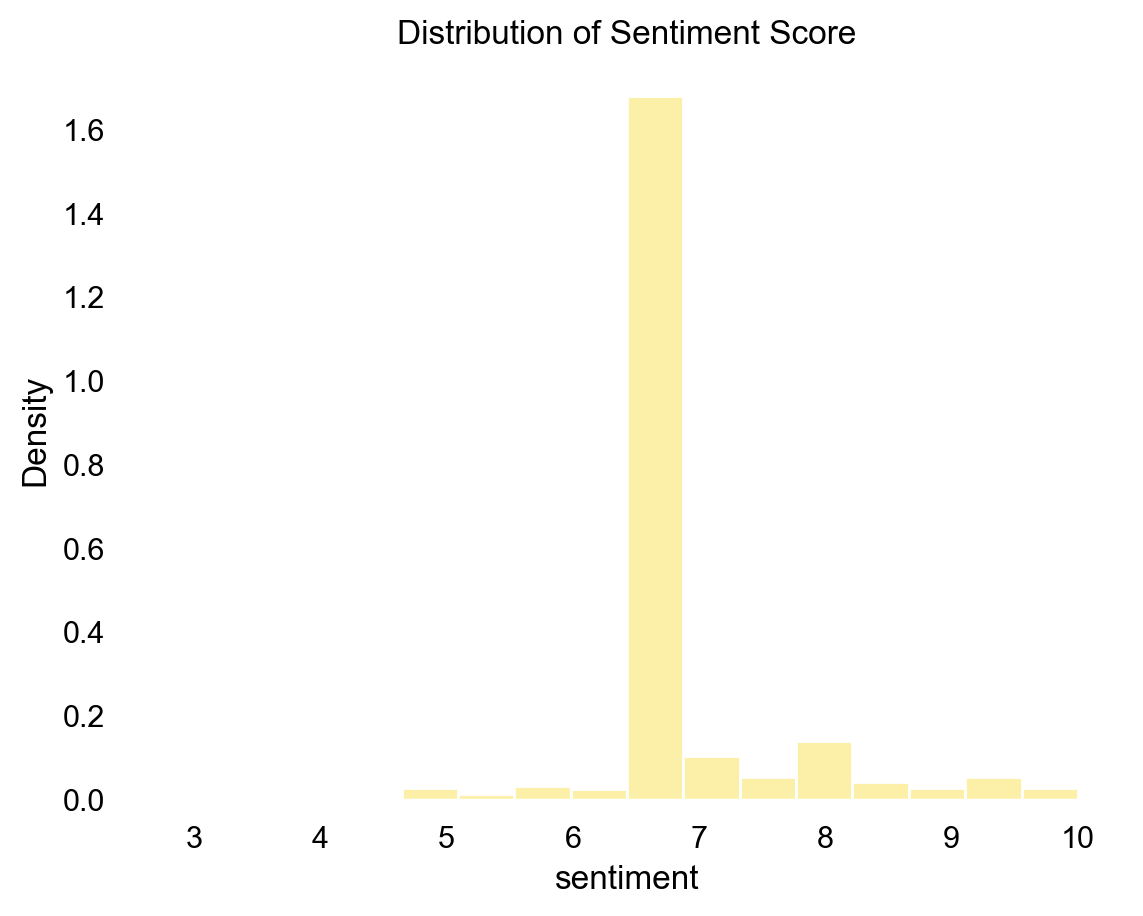

In [13]:
sns.histplot(data=train_df,
             x='sentiment',
             stat='density',
             color='#fcefa7',
            alpha=1.0).set(title='Distribution of Sentiment Score')

We see here that the sentiment score is skewed to the left, with a skew of approximately 1.49 and thus we will have to normalize it in the Feature Engineering portion of the notebook.

### Analyze most commonly used words

#### Convert string of list back to a list

In [14]:
# convert string of list back to a list
train_df['entity'] = train_df['entity'].map(lambda x: ast.literal_eval(x))
train_df['pos_sentiment_words'] = train_df['pos_sentiment_words'].map(lambda x: ast.literal_eval(x))
train_df['neg_sentiment_words'] = train_df['neg_sentiment_words'].map(lambda x: ast.literal_eval(x))

#### Create dataframe for sentences with sentiment scores that are in the 90th percentile (top 10%).

In [15]:
pct = 0.1
rows = len(train_df)

top_sentences = train_df.sort_values(by=['sentiment'],ascending=False).head(round(rows * pct))

#### Create dataframe for sentences with sentiment scores that are in the 10th percentile (bottom 10%).

In [16]:
pct = 0.1
rows = len(train_df)

bottom_sentences = train_df.sort_values(by=['sentiment'],ascending=True).head(round(rows * pct))

In [17]:
remove_entities = ['one','two','first','1','2','3','4','5','6','7','10','30',
                   'ref','kak','juga','ga','bro','kami','sa']

In [18]:
stopwords = stopwords.words('english')
stopwords.extend(['welcome','luck'])

In [19]:
def top_n_grams(corpus, n, ngram, stop):
    # Create a CountVectorizer object with specified n-gram range and stop words
    vec = CountVectorizer(ngram_range=ngram, stop_words=stop)
    # Convert the corpus into a bag of words representation
    bag_of_words = vec.fit_transform(corpus)
    # Calculate the sum of words across all documents
    sum_words = bag_of_words.sum(axis=0) 
    # Create a list of (word, count) pairs from the vocabulary and word counts
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sort the list of (word, count) pairs by count in descending order and select top n
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)[:n]
    # Store top n common n-grams in a dataframe
    df = pd.DataFrame(words_freq, columns=['text', 'count'])
    # Sort the dataframe by the count column in descending order
    df = df.sort_values(by='count', ascending=False)

    return df 

#### Visualize commonly appearing unigrams without stopwords

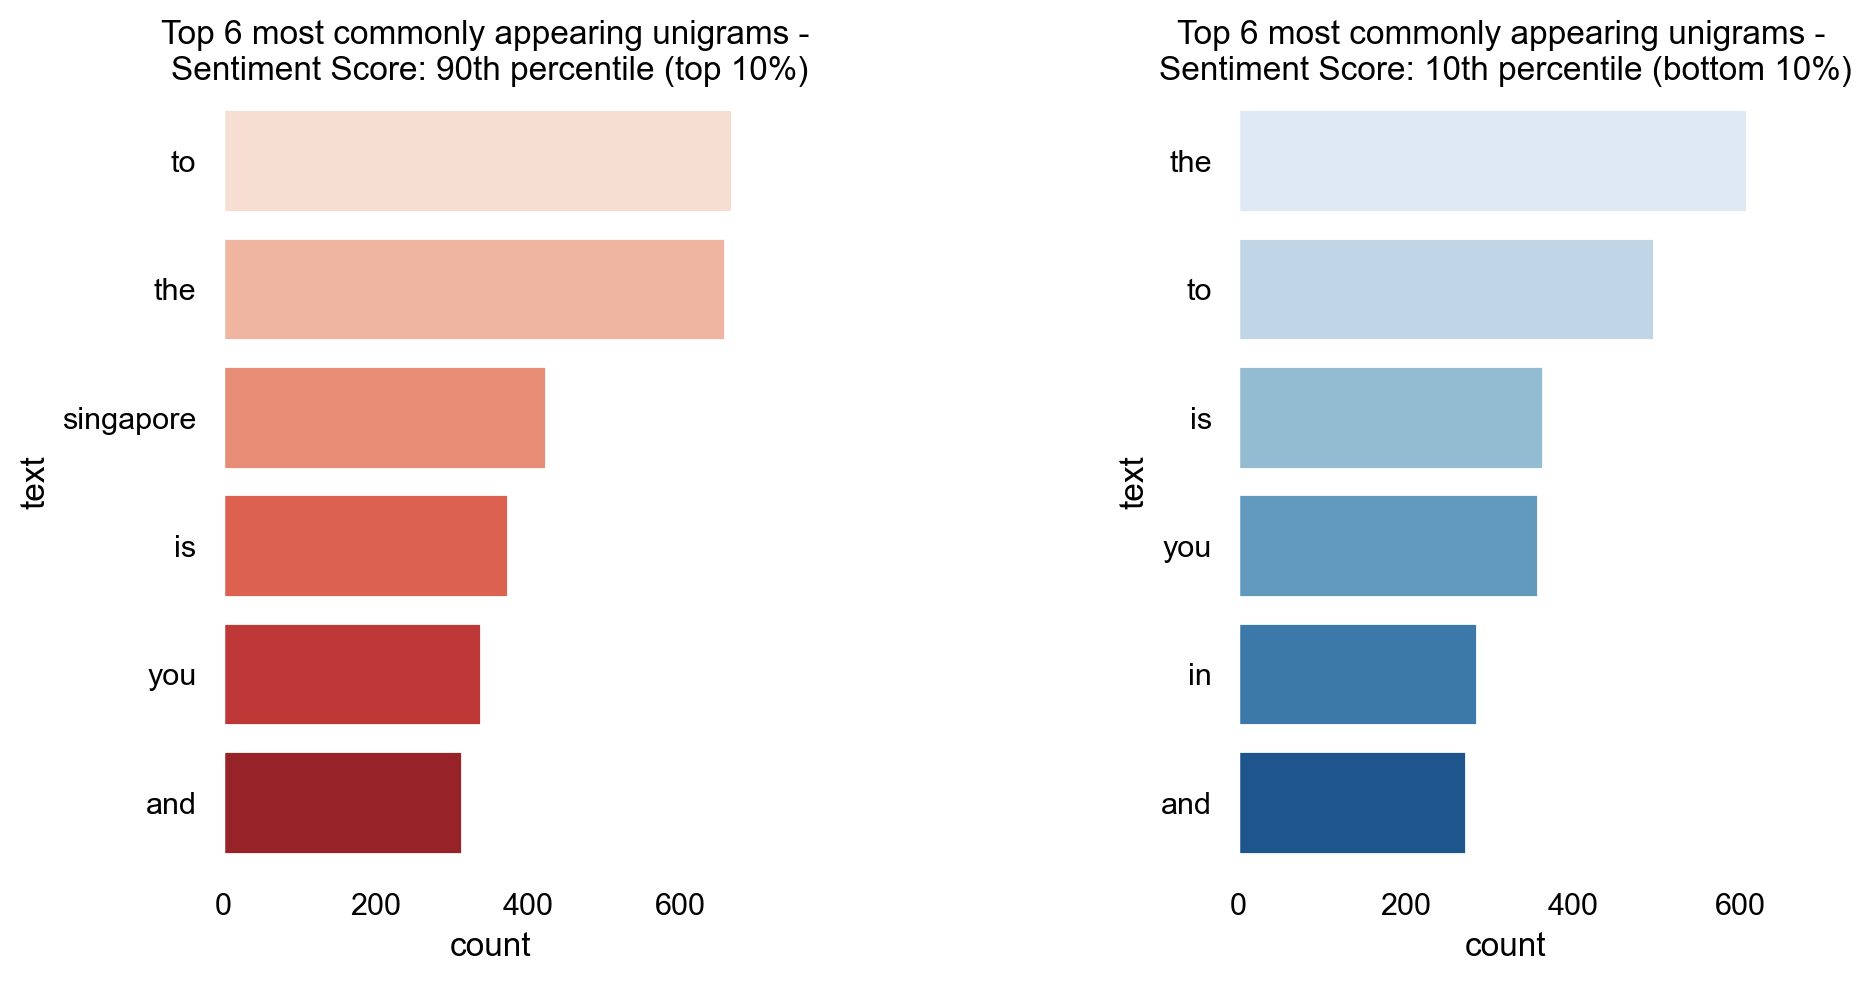

In [20]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=6, ngram=(1,1), stop=None),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 6 most commonly appearing unigrams - \nSentiment Score: 90th percentile (top 10%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=6, ngram=(1,1), stop=None),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 6 most commonly appearing unigrams - \nSentiment Score: 10th percentile (bottom 10%)')
None

Some unigrams do not really mean anything, such as 'to', 'the', 'is', etc. As such, we shall include stopwords in the next step.

#### Visualize commonly appearing unigrams with stopwords

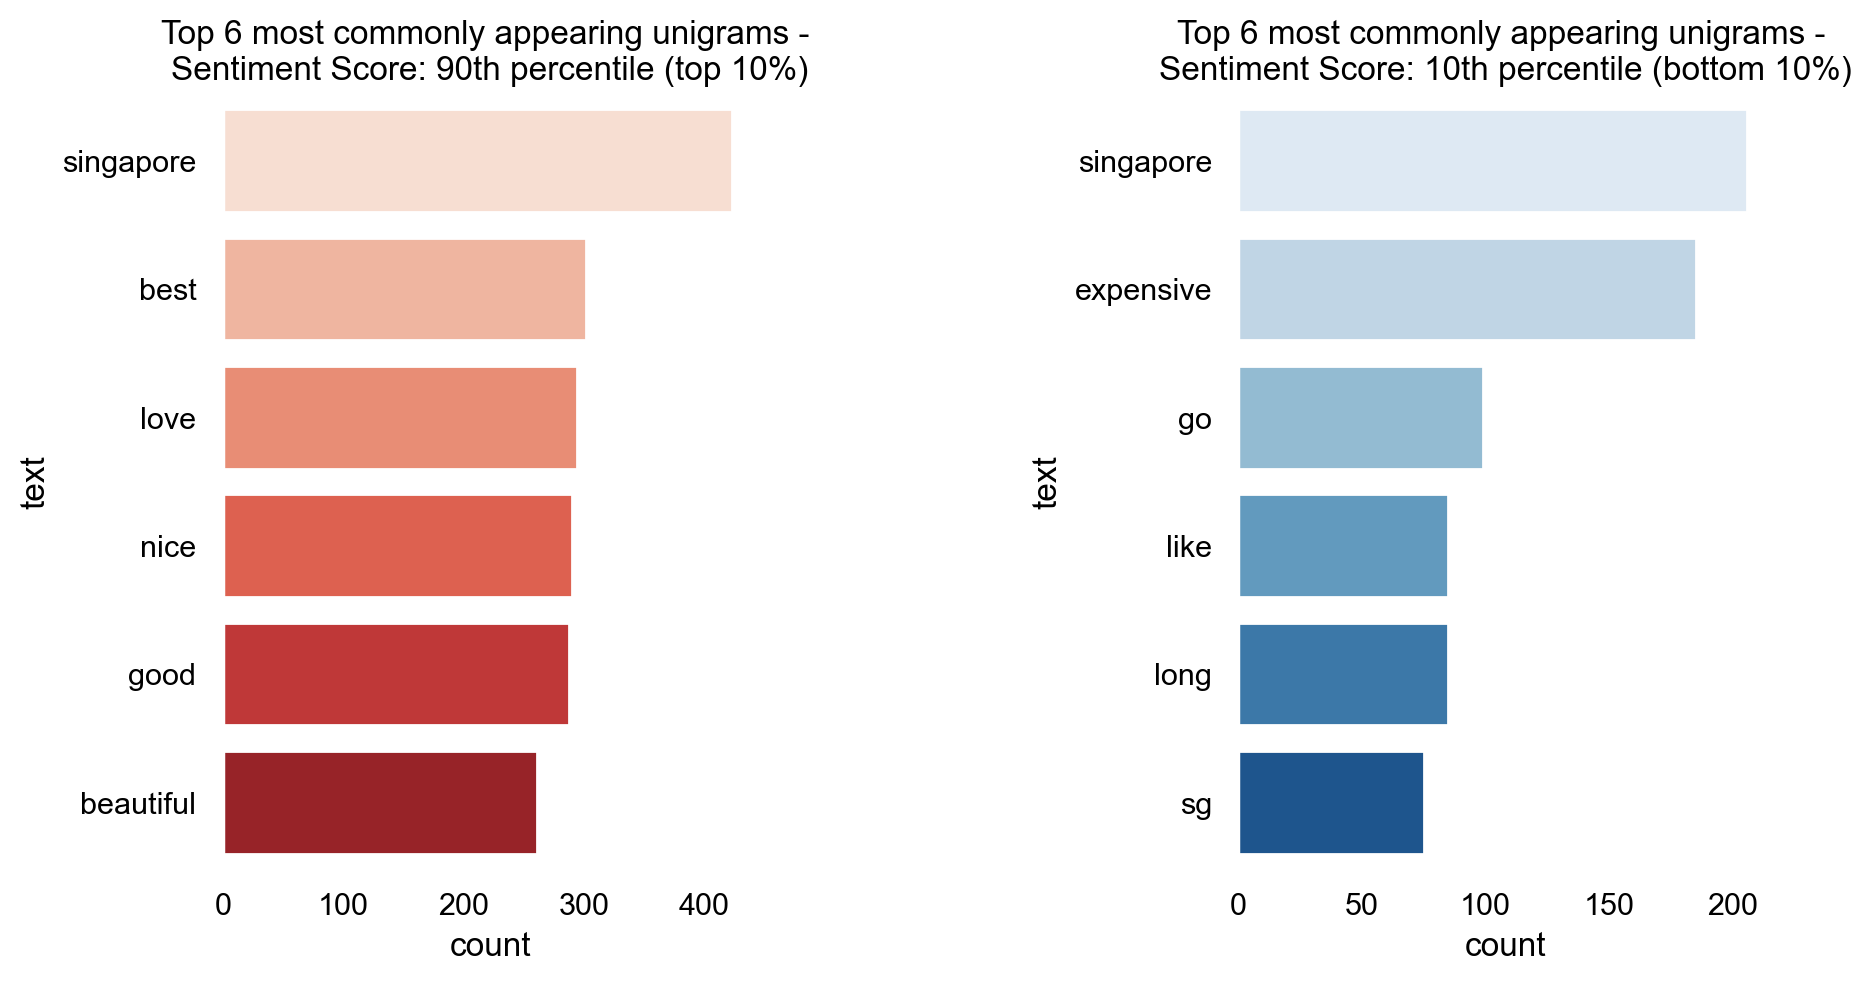

In [21]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=6, ngram=(1,1), stop=stopwords),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 6 most commonly appearing unigrams - \nSentiment Score: 90th percentile (top 10%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=6, ngram=(1,1), stop=stopwords),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 6 most commonly appearing unigrams - \nSentiment Score: 10th percentile (bottom 10%)')
None

With the use of stopwords, the top commonly appearing unigrams now have more meaning. 

However, it is still not extremely clear what the context is. As such, we shall look at bigrams to see if we can gain more insights. 

#### Visualize commonly appearing bigrams without stopwords

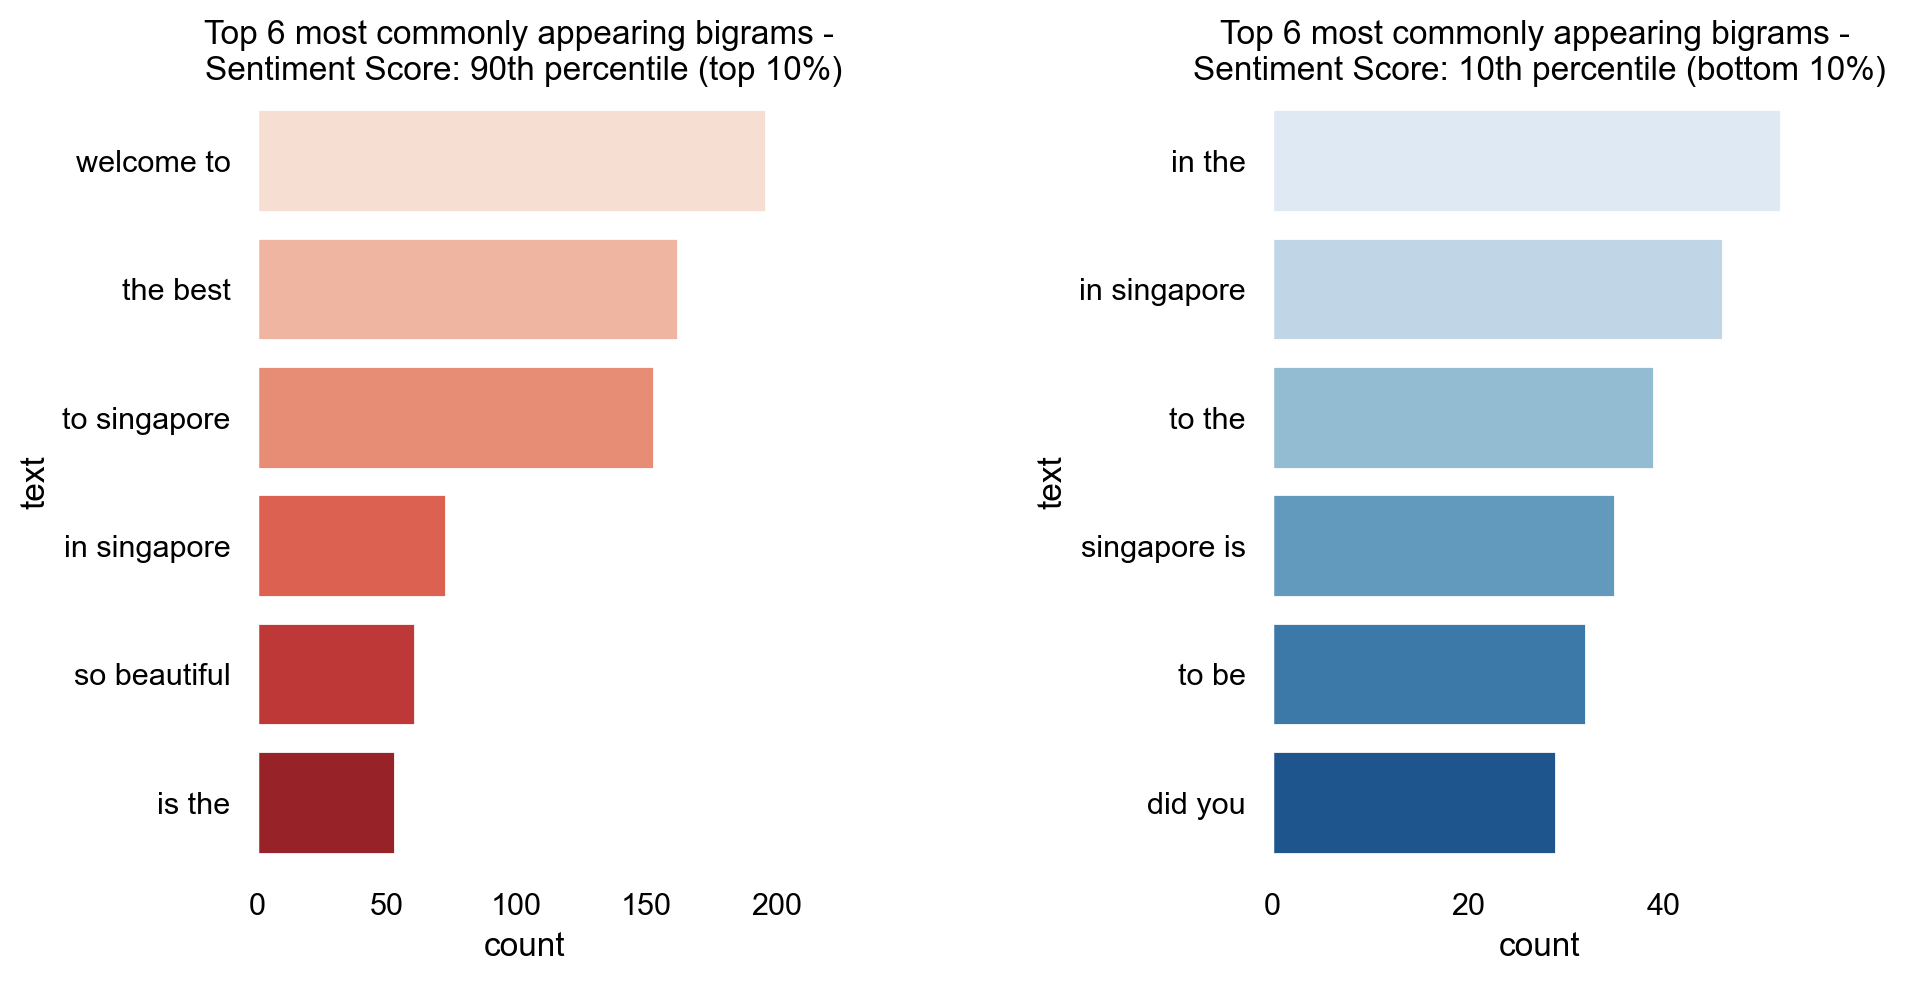

In [22]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=6, ngram=(2,2), stop=None),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 6 most commonly appearing bigrams - \nSentiment Score: 90th percentile (top 10%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=6, ngram=(2,2), stop=None),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 6 most commonly appearing bigrams - \nSentiment Score: 10th percentile (bottom 10%)')
None

Some bigrams do not really mean anything, such as 'to the', 'is the', 'to be', etc. As such, we shall include stopwords in the next step.

#### Visualize commonly appearing bigrams with stopwords

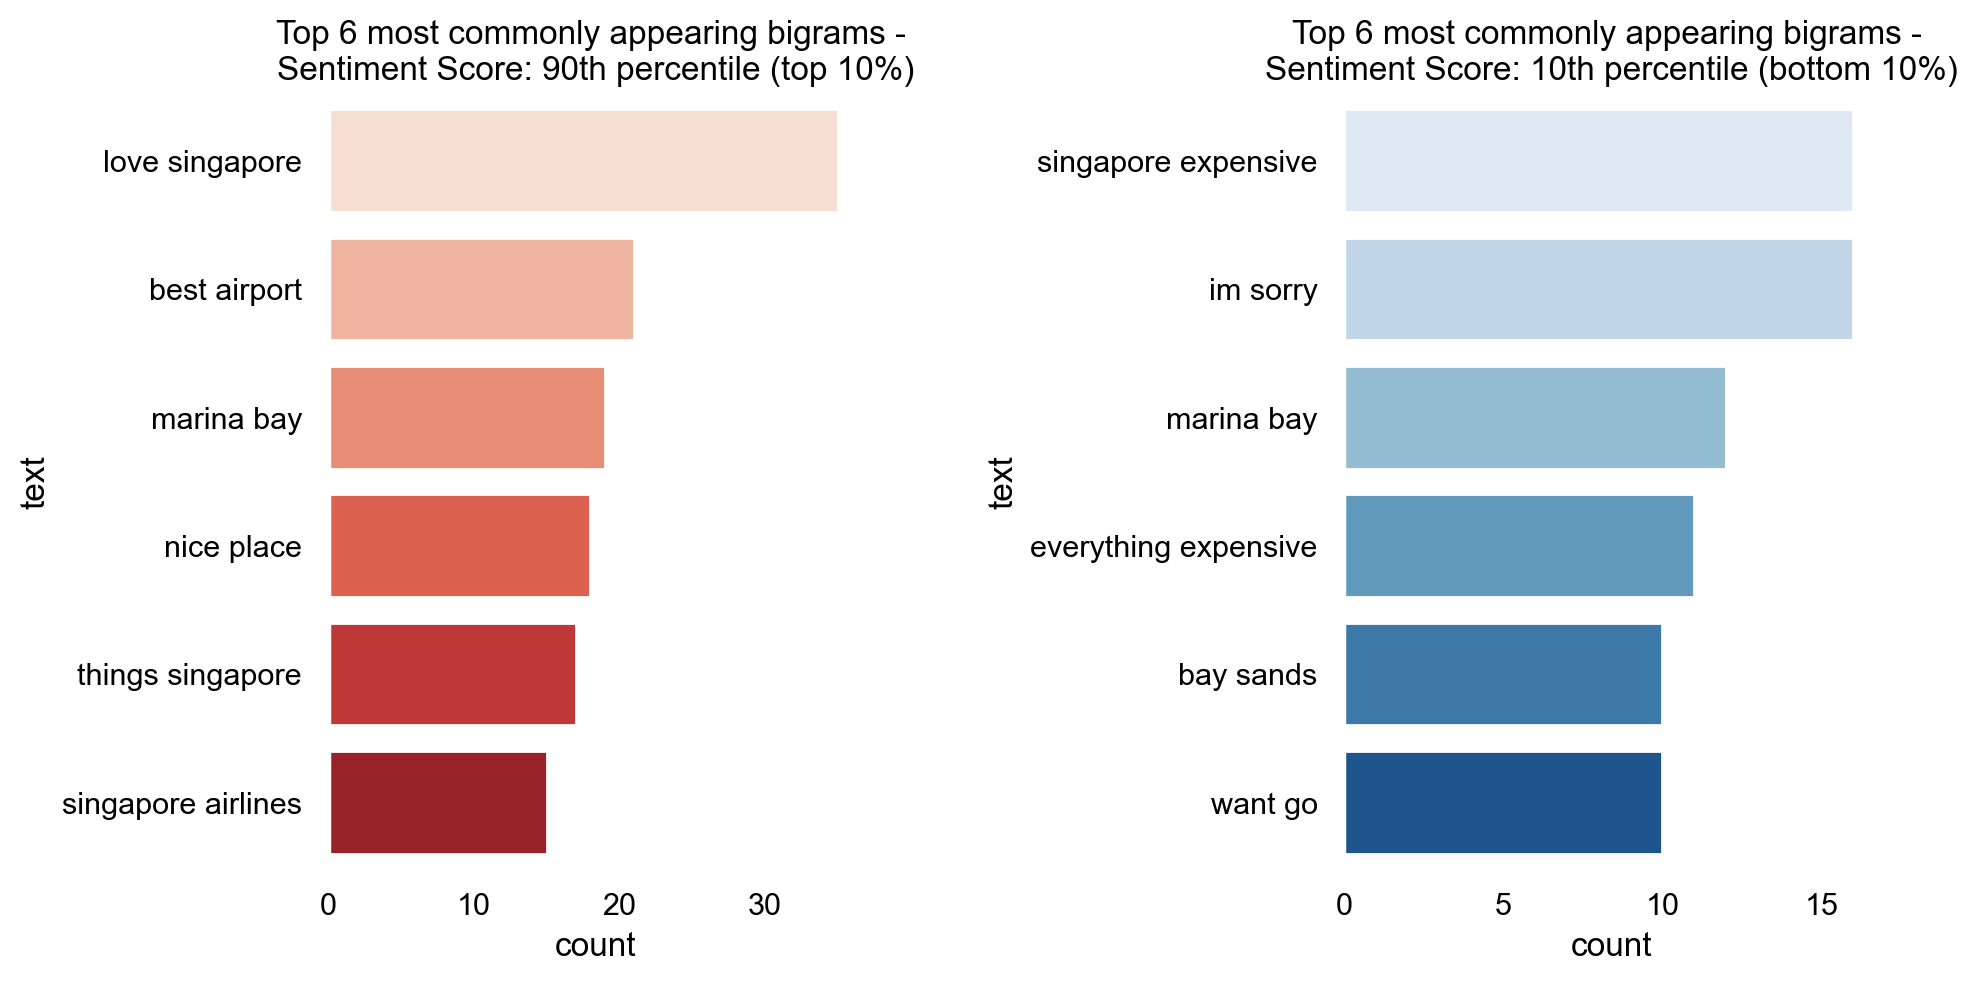

In [23]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.9)

sns.barplot(data=top_n_grams(top_sentences['sentence'], n=6, ngram=(2,2), stop=stopwords),
            x='count',y='text',
            ax=axes[0],
            palette='Reds',
            alpha=1.0).set(title='Top 6 most commonly appearing bigrams - \nSentiment Score: 90th percentile (top 10%)')
sns.barplot(data=top_n_grams(bottom_sentences['sentence'], n=6, ngram=(2,2), stop=stopwords),
            x='count',y='text',
            ax=axes[1],
            palette='Blues',
            alpha=1.0).set(title='Top 6 most commonly appearing bigrams - \nSentiment Score: 10th percentile (bottom 10%)')
None

With the use of stopwords, the top commonly appearing bigrams now have more meaning. 

In comparison to unigrams, bigrams offer a richer context, allowing us to discern word pairings such as 'best airport' rather than just the isolated word 'best.'

Considering both unigrams and bigrams, it becomes apparent that Singapore is well-received by many tourists, with favorable remarks highlighting its beauty, excellent airport, and airline services. However, unfavorable sentiments arise due to the country's relatively high costs.

A seemingly peculiar observation is the repeated appearance of 'marina bay' in both analyses. This phenomenon can be readily explained by the fact that popular tourist attractions, like 'marina bay,' tend to receive frequent mentions, regardless of tourists' eventual sentiment scores, owing to their inherent popularity and recognition.

In the next part, we shall look at the most commonly mentioned entities.

### Analyze most  commonly mentioned entities

#### Create dataframe for most commonly mentioned entities for sentences with sentiment scores that are in the 90th percentile (top 10%)

In [24]:
list_of_lists_top = [entities for entities in top_sentences['entity']]

word_counts_top = {}

# Loop through each sublist in the list of lists
for sublist in list_of_lists_top:
    # Loop through each string in the sublist
    for word in sublist:
        # need to swap out the word with the replacement from my other list
        if word in sg_entities_patterns_df['pattern'].values:
            # find the row number in which this word is found
            row_num = (sg_entities_patterns_df.index[sg_entities_patterns_df['pattern'] == word])[0]
            # replace word with value in 'sublocation'
            word = sg_entities_patterns_df['sublocation'][row_num]
        if word not in remove_entities:
            # Update the count in the dictionary
            word_counts_top[word] = word_counts_top.get(word, 0) + 1

In [25]:
# save entity and its corresponding count in a dataframe
word_counts_top_df = {'entity': [],'count': []}
for k,v in word_counts_top.items():
    word_counts_top_df['entity'].append(k)
    word_counts_top_df['count'].append(v)
word_counts_top_df = pd.DataFrame(word_counts_top_df)

In [26]:
word_counts_top_df = word_counts_top_df.sort_values(by=['count','entity'],
                                                    ascending=False)

In [27]:
word_counts_top_df.head(20)

,entity,count
1,singapore,370
4,food,70
22,shoppe at marina bay sand,19
24,garden by the bay,17
76,malaysia,15
63,singaporean,13
30,singapore airport,13
35,hawker centre,13
31,singapore airline,12
126,light show,11


#### Create dataframe for most commonly mentioned entities for sentences with sentiment scores that are in the 10th percentile (bottom 10%)

In [28]:
list_of_lists_bottom = [entities for entities in bottom_sentences['entity']]

word_counts_bottom = {}

# Loop through each sublist in the list of lists
for sublist in list_of_lists_bottom:
    # Loop through each string in the sublist
    for word in sublist:
        # need to swap out the word with the replacement from my other list
        if word in sg_entities_patterns_df['pattern'].values:
            # find the row number in which this word is found
            row_num = (sg_entities_patterns_df.index[sg_entities_patterns_df['pattern'] == word])[0]
            # replace word with value in 'sublocation'
            word = sg_entities_patterns_df['sublocation'][row_num]
        if word not in remove_entities:
            # Update the count in the dictionary            
            word_counts_bottom[word] = word_counts_bottom.get(word, 0) + 1

In [29]:
# save entity and its corresponding count in a dataframe
word_counts_bottom_df = {'entity': [],'count': []}
for k,v in word_counts_bottom.items():
    word_counts_bottom_df['entity'].append(k)
    word_counts_bottom_df['count'].append(v)
word_counts_bottom_df = pd.DataFrame(word_counts_bottom_df)

In [30]:
word_counts_bottom_df = word_counts_bottom_df.sort_values(by=['count','entity'],
                                                    ascending=False)

In [31]:
word_counts_bottom_df.head(20)

,entity,count
1,singapore,181
2,food,45
31,thailand,20
51,malaysia,18
321,un,12
15,shoppe at marina bay sand,12
58,asia,12
96,mrt,10
50,indonesia,10
185,english,10


#### Visualize most commonly mentioned entities for sentences with sentiment scores that are in the 90th percentile (top 10%) vs those with sentiment scores that are in the 10th percentile (bottom 10%) 

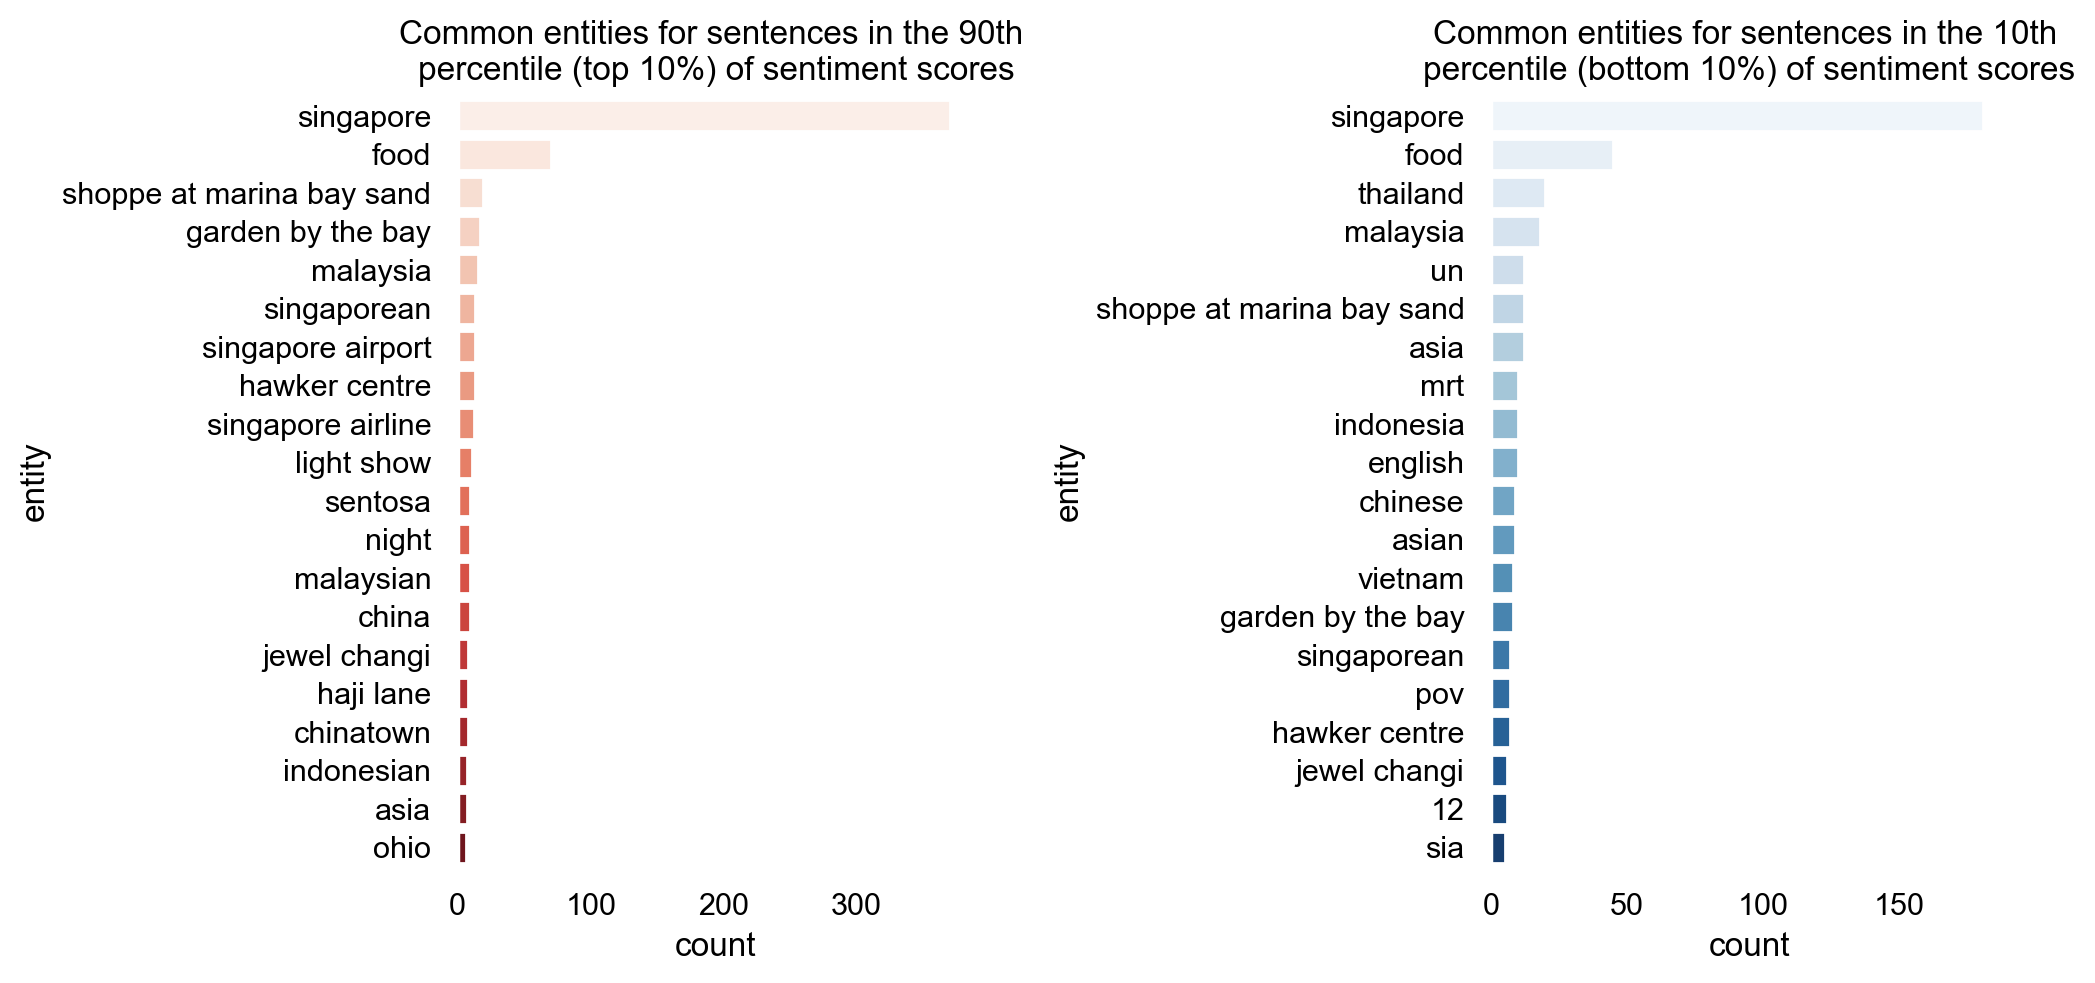

In [32]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
sns.barplot(data=word_counts_top_df.head(20),
            x='count',y='entity',
            ax=axes[0],
            palette='Reds').set(title='Common entities for sentences in the 90th \npercentile (top 10%) of sentiment scores')
sns.barplot(data=word_counts_bottom_df.head(20),
            x='count',y='entity',
            ax=axes[1],
            palette='Blues').set(title='Common entities for sentences in the 10th \npercentile (bottom 10%) of sentiment scores')
# Adjust the subplot layout parameters
fig.subplots_adjust(hspace=1.0, wspace=1.0)

This does not give us much information which is not surprising. As mentioned above, since tourists typically gravitate towards popular tourist locations, the frequency of mentions for these attractions remains high, irrespective of whether the tourists' eventual sentiment scores are low or high.

Instead, we should calculate the Net Promoter Score (NPS) for each entity and compare NPS across different entities.

### Compare Net Promoter Score (NPS) across entities

NPS = % Promoters - % Detractors

Promoters: Respondents who give a rating of 9 or 10.

Passives: Respondents who give a rating of 7 or 8. 

Detractors: Respondents who give a rating of 0 to 6. 

#### Create a dataframe where each entity (that appears in the scrapped dataset and `sg_entities_patterns_df`) has its own NPS. This dataframe will also have additional information such as positive and negative sentiment words frequently mentioned together with said entity.

In [33]:
# generate a list of all entities mentioned
list_of_lists_all = [entities for entities in train_df['entity']]

unique_entities_count = {}

# Loop through each sublist in the list of lists
for sublist in list_of_lists_all:
    # Loop through each string in the sublist
    for word in sublist:
        # need to swap out the word with the replacement from my other list
        # we will only keep entities that are in 'sg_entities_patterns_df'
        if word in sg_entities_patterns_df['pattern'].values:
            # find the row number in which this word is found
            row_num = (sg_entities_patterns_df.index[sg_entities_patterns_df['pattern'] == word])[0]
            # replace word with value in 'sublocation'
            word = sg_entities_patterns_df['sublocation'][row_num]
            if word not in remove_entities:
                # Update the count in the dictionary                 
                unique_entities_count[word] = unique_entities_count.get(word, 0) + 1
        

In [34]:
# save entity and its corresponding count in a dataframe
unique_entities_count_df = {'entity': [],'count': []}
for k,v in unique_entities_count.items():
    unique_entities_count_df['entity'].append(k)
    unique_entities_count_df['count'].append(v)
unique_entities_count_df = pd.DataFrame(unique_entities_count_df)

In [35]:
# add new columns
unique_entities_count_df['promoter_count'] = 0
unique_entities_count_df['detractor_count'] = 0
unique_entities_count_df['total_count'] = 0
unique_entities_count_df['pos_sentiment_words'] = 0
unique_entities_count_df['neg_sentiment_words'] = 0
unique_entities_count_df['interest_1'] = ''
unique_entities_count_df['interest_2'] = ''
unique_entities_count_df['indoor_outdoor'] = ''
# empty list function
def create_empty_list():
    return []

# Apply the function to each cell
unique_entities_count_df['pos_sentiment_words'] = unique_entities_count_df['pos_sentiment_words'].apply(lambda x: create_empty_list())
unique_entities_count_df['neg_sentiment_words'] = unique_entities_count_df['neg_sentiment_words'].apply(lambda x: create_empty_list())

unique_entities_count_df.head(20)

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor
0,singapore airport,43,0,0,0,[],[],,,
1,future world exhibition,8,0,0,0,[],[],,,
2,artscience museum,22,0,0,0,[],[],,,
3,garden by the bay,127,0,0,0,[],[],,,
4,skyway,10,0,0,0,[],[],,,
5,floral fantasy,10,0,0,0,[],[],,,
6,light show,59,0,0,0,[],[],,,
7,fort canning,13,0,0,0,[],[],,,
8,arab street,21,0,0,0,[],[],,,
9,food,356,0,0,0,[],[],,,


In [36]:
# calculate nps for each entity
for index, entities in enumerate(train_df['entity']):
    # extract the positive and negative sentiment words as a list
    pos_list = train_df['pos_sentiment_words'].loc[index]
    neg_list = train_df['neg_sentiment_words'].loc[index]
    for entity in entities:
        # we only want the locations mentioned in sg_entities_patterns_df
        if entity in sg_entities_patterns_df['pattern'].values:
            # find the row number in which this word is found
            row_num = (sg_entities_patterns_df.index[sg_entities_patterns_df['pattern'] == entity])[0]
            # replace word with value in 'sublocation'
            entity = sg_entities_patterns_df['sublocation'][row_num]        
            # find the row in which this entity is saved in for unique_entities_count_df
            row_num = (unique_entities_count_df.index[unique_entities_count_df['entity'] == entity])
            unique_entities_count_df['total_count'].loc[row_num] = unique_entities_count_df['total_count'].loc[row_num] + 1
            
            # save the extracted pos and neg words in a list
            unique_entities_count_df['pos_sentiment_words'].loc[row_num[0]] = pos_list + unique_entities_count_df['pos_sentiment_words'].loc[row_num[0]]
            unique_entities_count_df['neg_sentiment_words'].loc[row_num[0]] = neg_list + unique_entities_count_df['neg_sentiment_words'].loc[row_num[0]]
            
            # add to the respective count if the sentence is a promoter / detractor
            if train_df['sentiment'].loc[index] >= 9:
                unique_entities_count_df['promoter_count'].loc[row_num] = unique_entities_count_df['promoter_count'].loc[row_num] + 1
            elif train_df['sentiment'].loc[index] < 6:
                unique_entities_count_df['detractor_count'].loc[row_num] = unique_entities_count_df['detractor_count'].loc[row_num] + 1

/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_96450/2198707034.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['total_count'].loc[row_num] = unique_entities_count_df['total_count'].loc[row_num] + 1
/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_96450/2198707034.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['pos_sentiment_words'].loc[row_num[0]] = pos_list + unique_entities_count_df['pos_sentiment_words'].loc[row_num[0]]
/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_96450/2198707034.py:19: SettingWithCopyWarning: 
A value

In [37]:
# nps formula
unique_entities_count_df['nps'] = ((unique_entities_count_df['promoter_count'] - unique_entities_count_df['detractor_count']) / unique_entities_count_df['count']) * 100

In [38]:
unique_entities_count_df.head(20)

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor,nps
0,singapore airport,43,4,0,43,"[amazing, whole, best, live, awesome, love, fa...","[spent, crying, impossible, spent, down, long,...",,,,9.302326
1,future world exhibition,8,0,2,8,"[best, absolutely, beautiful, best, better, be...","[mean, mean, down, chicken, mean, hidden, bad,...",,,,-25.000000
2,artscience museum,22,1,1,22,"[cool, free, top, absolutely, amazing, really,...","[few, tight, little, down, other, expensive]",,,,0.000000
3,garden by the bay,127,3,4,127,"[loved, most, popular, real, free, gorgeous, l...","[closed, closed, sorry, spent, other, unbeliev...",,,,-0.787402
4,skyway,10,0,1,10,"[best, absolutely, beautiful, best, better, be...","[mean, mean, down, chicken, mean, hidden, bad,...",,,,-10.000000
5,floral fantasy,10,0,0,10,"[new, far, bright, famous, colorful, top, most...","[few, insane]",,,,0.000000
6,light show,59,1,2,59,"[cheap, better, free, free, amazing, beautiful...","[fucking, harder, expensive, fucking, down, do...",,,,-1.694915
7,fort canning,13,0,1,13,"[nice, straight, completely, free, early, most...",[expensive],,,,-7.692308
8,arab street,21,0,2,21,"[hahaha, free, free, free, certain, free, free...","[down, expensive]",,,,-9.523810
9,food,356,11,30,356,"[amazing, cool, pretty, amazing, amazing, lol,...","[expensive, due, expensive, seriously, fucking...",,,,-5.337079


#### Add additional columns that provide more context to the entity such as the type of tourist attraction (amusement park, shopping, museum, etc.) and whether it is an indoor or outdoor attraction

In [39]:
# add the 'interest_1', 'interest_2' and 'indoor_outdoor' info to the dataframe
for index, entity in enumerate(unique_entities_count_df['entity']):
    # find the matching entity in 'sg_entities_patterns_df' and get the row_num
    row_num = sg_entities_patterns_df.index[sg_entities_patterns_df['sublocation'] == entity][0]
    unique_entities_count_df['interest_1'].loc[index] = sg_entities_patterns_df['interest_1'].loc[row_num]
    unique_entities_count_df['interest_2'].loc[index] = sg_entities_patterns_df['interest_2'].loc[row_num]
    unique_entities_count_df['indoor_outdoor'].loc[index] = sg_entities_patterns_df['indoor_outdoor'].loc[row_num]

unique_entities_count_df

/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_96450/3074340239.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['interest_1'].loc[index] = sg_entities_patterns_df['interest_1'].loc[row_num]
/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_96450/3074340239.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['interest_2'].loc[index] = sg_entities_patterns_df['interest_2'].loc[row_num]
/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_96450/3074340239.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor,nps
0,singapore airport,43,4,0,43,"[amazing, whole, best, live, awesome, love, fa...","[spent, crying, impossible, spent, down, long,...",transport,recreation,indoor,9.302326
1,future world exhibition,8,0,2,8,"[best, absolutely, beautiful, best, better, be...","[mean, mean, down, chicken, mean, hidden, bad,...",art,NaN,indoor,-25.000000
2,artscience museum,22,1,1,22,"[cool, free, top, absolutely, amazing, really,...","[few, tight, little, down, other, expensive]",museum,NaN,indoor,0.000000
3,garden by the bay,127,3,4,127,"[loved, most, popular, real, free, gorgeous, l...","[closed, closed, sorry, spent, other, unbeliev...",nature,architecture,outdoor,-0.787402
4,skyway,10,0,1,10,"[best, absolutely, beautiful, best, better, be...","[mean, mean, down, chicken, mean, hidden, bad,...",architecture,nature,outdoor,-10.000000
...,...,...,...,...,...,...,...,...,...,...,...
156,people park centre,1,0,0,1,[],[],shopping,NaN,indoor,0.000000
157,suntec city,1,0,0,1,[],[],shopping,NaN,indoor,0.000000
158,beauty world centre,1,0,0,1,[top],[],shopping,NaN,indoor,0.000000
159,nex,1,0,0,1,[],[],shopping,NaN,indoor,0.000000


#### Change the list of sentiment words into a dictionary instead so that it will be easier to visualize later.

In [40]:
# for positive words
for index, list_of_strings in enumerate(unique_entities_count_df['pos_sentiment_words']):
    dictionary = {}
    final_dict = {'sentiment_word': [],'count': []}
    for sentiment_word in list_of_strings:
        dictionary[sentiment_word] = dictionary.get(sentiment_word,0) + 1
    for k, v in dictionary.items():
        final_dict['sentiment_word'].append(k)
        final_dict['count'].append(v)
    # save in the cell
    unique_entities_count_df['pos_sentiment_words'][index] = final_dict
    
# for negative words
for index, list_of_strings in enumerate(unique_entities_count_df['neg_sentiment_words']):
    dictionary = {}
    final_dict = {'sentiment_word': [],'count': []}
    for sentiment_word in list_of_strings:
        dictionary[sentiment_word] = dictionary.get(sentiment_word,0) + 1
    for k, v in dictionary.items():
        final_dict['sentiment_word'].append(k)
        final_dict['count'].append(v)
    # save in the cell
    unique_entities_count_df['neg_sentiment_words'][index] = final_dict

/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_96450/949506435.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['pos_sentiment_words'][index] = final_dict
/var/folders/r4/61_m3nz133bcpt1gp9t0vyq00000gn/T/ipykernel_96450/949506435.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_entities_count_df['neg_sentiment_words'][index] = final_dict


In [41]:
unique_entities_count_df

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor,nps
0,singapore airport,43,4,0,43,"{'sentiment_word': ['amazing', 'whole', 'best'...","{'sentiment_word': ['spent', 'crying', 'imposs...",transport,recreation,indoor,9.302326
1,future world exhibition,8,0,2,8,"{'sentiment_word': ['best', 'absolutely', 'bea...","{'sentiment_word': ['mean', 'down', 'chicken',...",art,NaN,indoor,-25.000000
2,artscience museum,22,1,1,22,"{'sentiment_word': ['cool', 'free', 'top', 'ab...","{'sentiment_word': ['few', 'tight', 'little', ...",museum,NaN,indoor,0.000000
3,garden by the bay,127,3,4,127,"{'sentiment_word': ['loved', 'most', 'popular'...","{'sentiment_word': ['closed', 'sorry', 'spent'...",nature,architecture,outdoor,-0.787402
4,skyway,10,0,1,10,"{'sentiment_word': ['best', 'absolutely', 'bea...","{'sentiment_word': ['mean', 'down', 'chicken',...",architecture,nature,outdoor,-10.000000
...,...,...,...,...,...,...,...,...,...,...,...
156,people park centre,1,0,0,1,"{'sentiment_word': [], 'count': []}","{'sentiment_word': [], 'count': []}",shopping,NaN,indoor,0.000000
157,suntec city,1,0,0,1,"{'sentiment_word': [], 'count': []}","{'sentiment_word': [], 'count': []}",shopping,NaN,indoor,0.000000
158,beauty world centre,1,0,0,1,"{'sentiment_word': ['top'], 'count': [1]}","{'sentiment_word': [], 'count': []}",shopping,NaN,indoor,0.000000
159,nex,1,0,0,1,"{'sentiment_word': [], 'count': []}","{'sentiment_word': [], 'count': []}",shopping,NaN,indoor,0.000000


#### Visualize most frequently mentioned entities and their corresponding NPS score

In [42]:
unique_entities_count_df.head(30)

,entity,count,promoter_count,detractor_count,total_count,pos_sentiment_words,neg_sentiment_words,interest_1,interest_2,indoor_outdoor,nps
0,singapore airport,43,4,0,43,"{'sentiment_word': ['amazing', 'whole', 'best'...","{'sentiment_word': ['spent', 'crying', 'imposs...",transport,recreation,indoor,9.302326
1,future world exhibition,8,0,2,8,"{'sentiment_word': ['best', 'absolutely', 'bea...","{'sentiment_word': ['mean', 'down', 'chicken',...",art,NaN,indoor,-25.000000
2,artscience museum,22,1,1,22,"{'sentiment_word': ['cool', 'free', 'top', 'ab...","{'sentiment_word': ['few', 'tight', 'little', ...",museum,NaN,indoor,0.000000
3,garden by the bay,127,3,4,127,"{'sentiment_word': ['loved', 'most', 'popular'...","{'sentiment_word': ['closed', 'sorry', 'spent'...",nature,architecture,outdoor,-0.787402
4,skyway,10,0,1,10,"{'sentiment_word': ['best', 'absolutely', 'bea...","{'sentiment_word': ['mean', 'down', 'chicken',...",architecture,nature,outdoor,-10.000000
5,floral fantasy,10,0,0,10,"{'sentiment_word': ['new', 'far', 'bright', 'f...","{'sentiment_word': ['few', 'insane'], 'count':...",nature,architecture,indoor,0.000000
6,light show,59,1,2,59,"{'sentiment_word': ['cheap', 'better', 'free',...","{'sentiment_word': ['fucking', 'harder', 'expe...",art,NaN,outdoor,-1.694915
7,fort canning,13,0,1,13,"{'sentiment_word': ['nice', 'straight', 'compl...","{'sentiment_word': ['expensive'], 'count': [1]}",park,heritage,outdoor,-7.692308
8,arab street,21,0,2,21,"{'sentiment_word': ['hahaha', 'free', 'certain...","{'sentiment_word': ['down', 'expensive'], 'cou...",culture,NaN,outdoor,-9.523810
9,food,356,11,30,356,"{'sentiment_word': ['amazing', 'cool', 'pretty...","{'sentiment_word': ['expensive', 'due', 'serio...",food and drinks,NaN,indoor,-5.337079


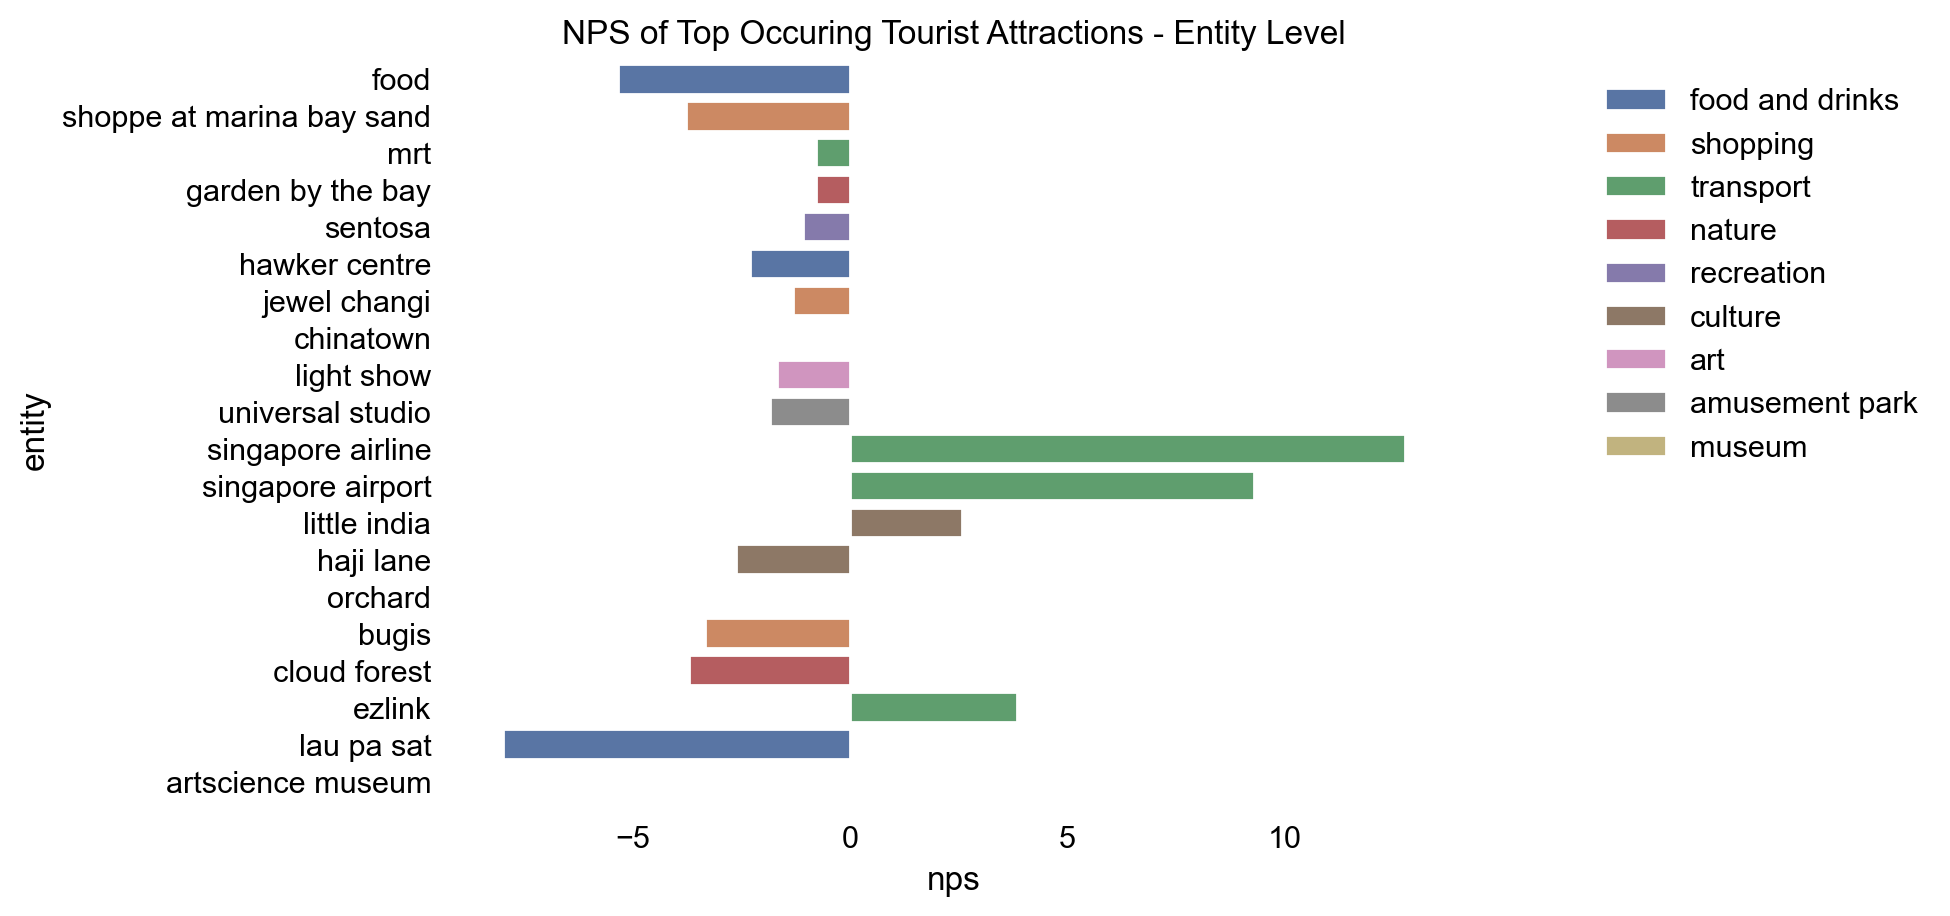

In [178]:
# sort by count
unique_entities_count_df = unique_entities_count_df.sort_values(by=['count','nps','entity'],
                                                                ascending=False)
sns.barplot(data=unique_entities_count_df.head(20),x='nps',y='entity', 
            hue='interest_1',
            dodge=False).set(title='NPS of Top Occuring Tourist Attractions - Entity Level')

plt.legend(frameon=False,loc='upper right',bbox_to_anchor=(1.5, 1))

[Text(0.5, 1.0, 'NPS of Top Occuring Tourist Attractions - Grouped by by Type')]

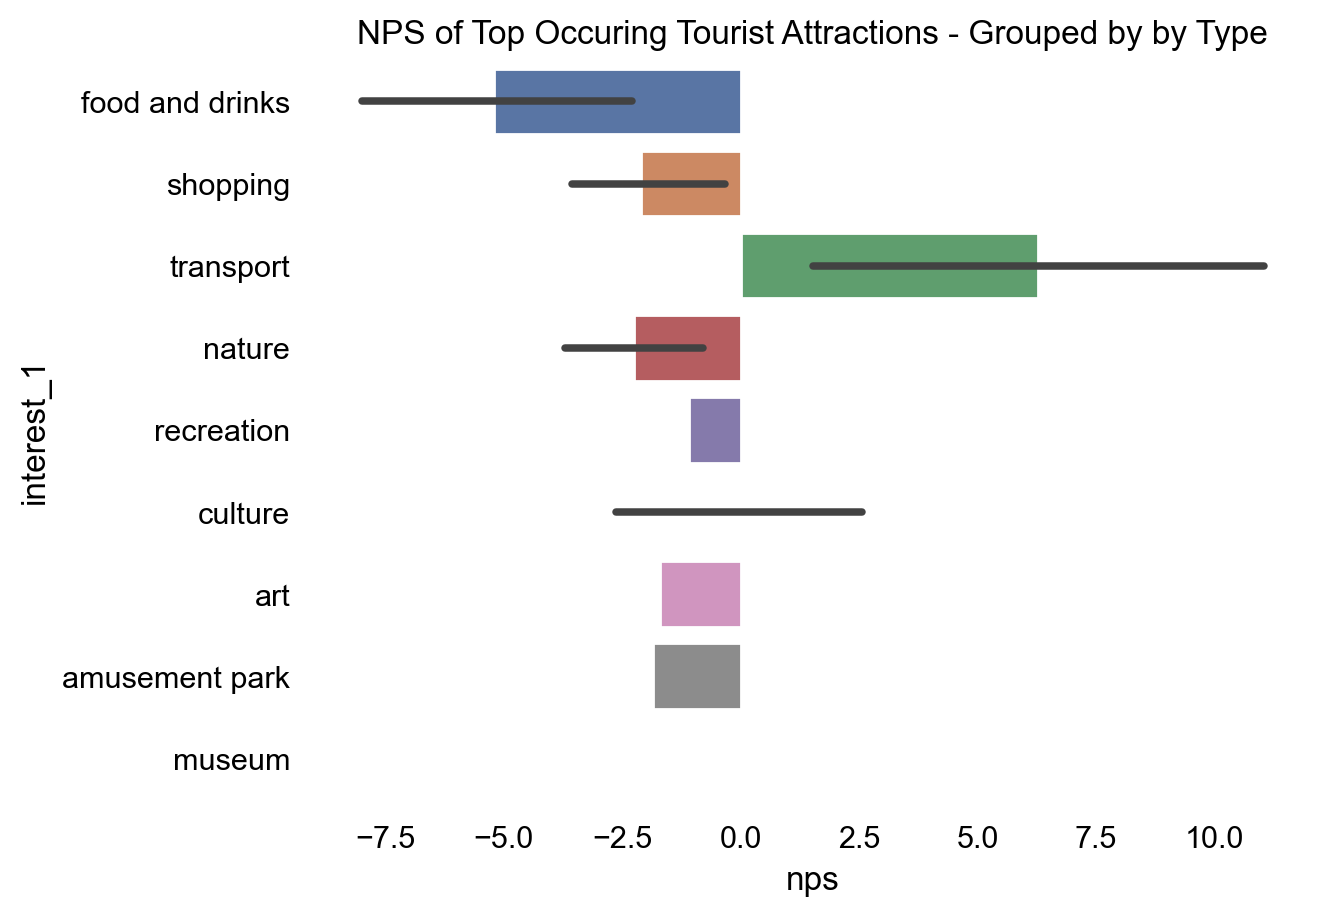

In [177]:
sns.barplot(data=unique_entities_count_df.head(20),x='nps',y='interest_1').set(title='NPS of Top Occuring Tourist Attractions - Grouped by by Type')

The analysis reveals notable variations in the Net Promoter Scores (NPS) across different entity categories. Specifically, 'transport' related entities exhibit significantly higher NPS ratings, whereas 'food and drinks' related entities demonstrate comparatively lower NPS values. On the other hand, entities related to culture, museums, and recreation tend to show a more neutral NPS sentiment.

This observation finds partial validation in the unigram and bigram analyses, where sentences mentioning aspects like 'Singapore airline' and 'airport' ('transport') receive notably high sentiment scores.

In the subsequent section, we will delve into the frequently mentioned positive and negative sentiment words to see if we can further explain factors contributing to the aforementioned NPS.

### Extract positive and negative sentiment words

#### Create 2 new dataframes that contain positive and negative sentiment words and the corresponding count

In [45]:
# reset sorting
unique_entities_count_df = unique_entities_count_df.sort_index()

In [46]:
def add_counts(sentiment_words, counts, combined_dict):
    for word, count in zip(sentiment_words, counts):
        if word in combined_dict['sentiment_word']:
            # find the index of the word in the list saved in combined_dict['sentiment_words']
            index_of_word = combined_dict['sentiment_word'].index(word)
            combined_dict['count'][index_of_word] += count
        else:
            combined_dict['sentiment_word'].append(word)
            combined_dict['count'].append(count)
    return combined_dict

In [47]:
# new dictionary
pos_sentiment_words_dict = {'sentiment_word':[],'count':[]}
neg_sentiment_words_dict = {'sentiment_word':[],'count':[]}

In [48]:
# for positive words
for index, interest_1 in enumerate(unique_entities_count_df['pos_sentiment_words']):
    # Add pos_sentiment_words_dict to the combined_dict
    combined_dict = pos_sentiment_words_dict

    # Add counts from unique_entities_count_df['pos_sentiment_words'][index] to the combined_dict
    add_counts(unique_entities_count_df['pos_sentiment_words'][index]['sentiment_word'], unique_entities_count_df['pos_sentiment_words'][index]['count'],combined_dict)

    # save the combined_dict in pos_sentiment_words_dict
    pos_sentiment_words_dict = combined_dict

# save as dataframe
pos_sentiment_words_df = pd.DataFrame(pos_sentiment_words_dict)

In [49]:
# for negitive words
for index, interest_1 in enumerate(unique_entities_count_df['neg_sentiment_words']):
    # Add pos_sentiment_words_dict to the combined_dict
    combined_dict = neg_sentiment_words_dict

    # Add counts from unique_entities_count_df['neg_sentiment_words'][index] to the combined_dict
    add_counts(unique_entities_count_df['neg_sentiment_words'][index]['sentiment_word'], unique_entities_count_df['neg_sentiment_words'][index]['count'],combined_dict)

    # save the combined_dict in neg_sentiment_words_dict
    neg_sentiment_words_dict = combined_dict

# save as dataframe
neg_sentiment_words_df = pd.DataFrame(neg_sentiment_words_dict)

In [50]:
pos_sentiment_words_df = pos_sentiment_words_df.sort_values(by=['count'],ascending=False)
neg_sentiment_words_df = neg_sentiment_words_df.sort_values(by=['count'],ascending=False)

#### Visualize the positive and negative sentiment words commonly mentioned

<Axes: xlabel='count', ylabel='sentiment_word'>

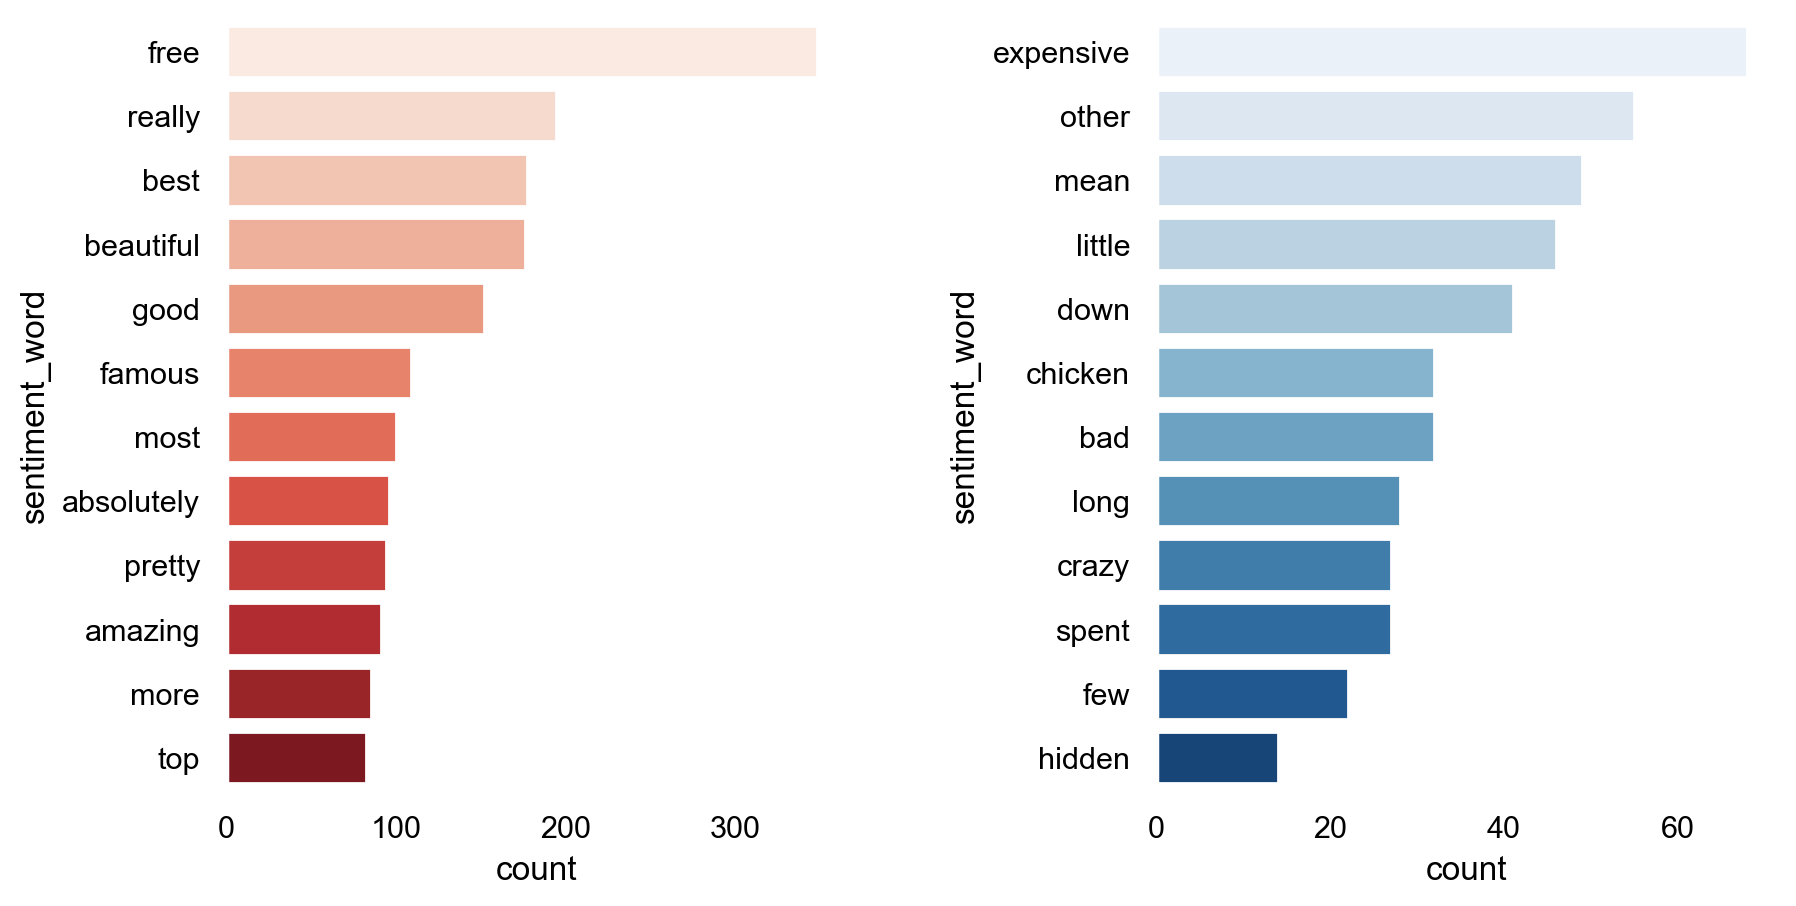

In [51]:
fig, axes = plt.subplots(1,2,figsize=[10,5])
# adjust padding
plt.subplots_adjust(wspace=0.5)

sns.barplot(data=pos_sentiment_words_df.head(12),
            x='count',y='sentiment_word',
            ax=axes[0],
           palette='Reds',).set(title='Top Occuring Positive Sentiment Words')
sns.barplot(data=neg_sentiment_words_df.head(12),
            x='count',y='sentiment_word',
            ax=axes[1],
           palette='Blues',).set(title='Top Occuring Negative Sentiment Words')

As with the unigrams and bigrams analyses, favorable remarks highlights Singapore's beauty and pleasant ambiance, while unfavorable remarks center around its perceived expensiveness.  

Here we see that the top most mentioned positive and negative sentiment words are related: 'free' and 'expensive'.  This leads us to the conclusion that tourists visiting Singapore exhibit a strong sensitivity to pricing. Consequently, this explains the varying Net Promoter Scores (NPS) for different types of tourist attractions:- 

- The perceived high cost of living in Singapore contributes to lower NPS scores for interests like 'food and drinks' and 'shopping'. 

- Conversely, tourist attractions such as 'culture' and 'museum' tend to evoke more neutral scores. This is likely because while the attractions themselves are often free, the surrounding amenities may be costly. Additionally, museums often feature both free and paid sections, which could account for the neutral sentiment. 

- 'Transport', however, garners considerable appreciation from tourists, with numerous accolades lauding the Singapore airport and airlines as exemplary and among the best in the industry.

<a id='feature_engineering'></a>

## 5. Feature Engineering

#### As mentioned in EDA, the sentiment scores are skewed to the left. To reduce the skew, apply transformation.

In [52]:
train_df['sentiment'] = (train_df['sentiment'])**(1 / 1.25)

In [53]:
statistical_data(train_df, 'sentiment')

Statistical Data for sentiment
Mean: 4.5883468112291705
Standard Deviation: 0.4648977128331802
p: 0.0
Since p <= 0.07, it can be concluded that sentiment does not follow a normal distribution (reject H0)
Distribution of sentiment is positively skewed, with skew at: 1.3303415587289933


/Users/edenng/anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


[Text(0.5, 1.0, 'Distribution of Sentiment Score after Transformation')]

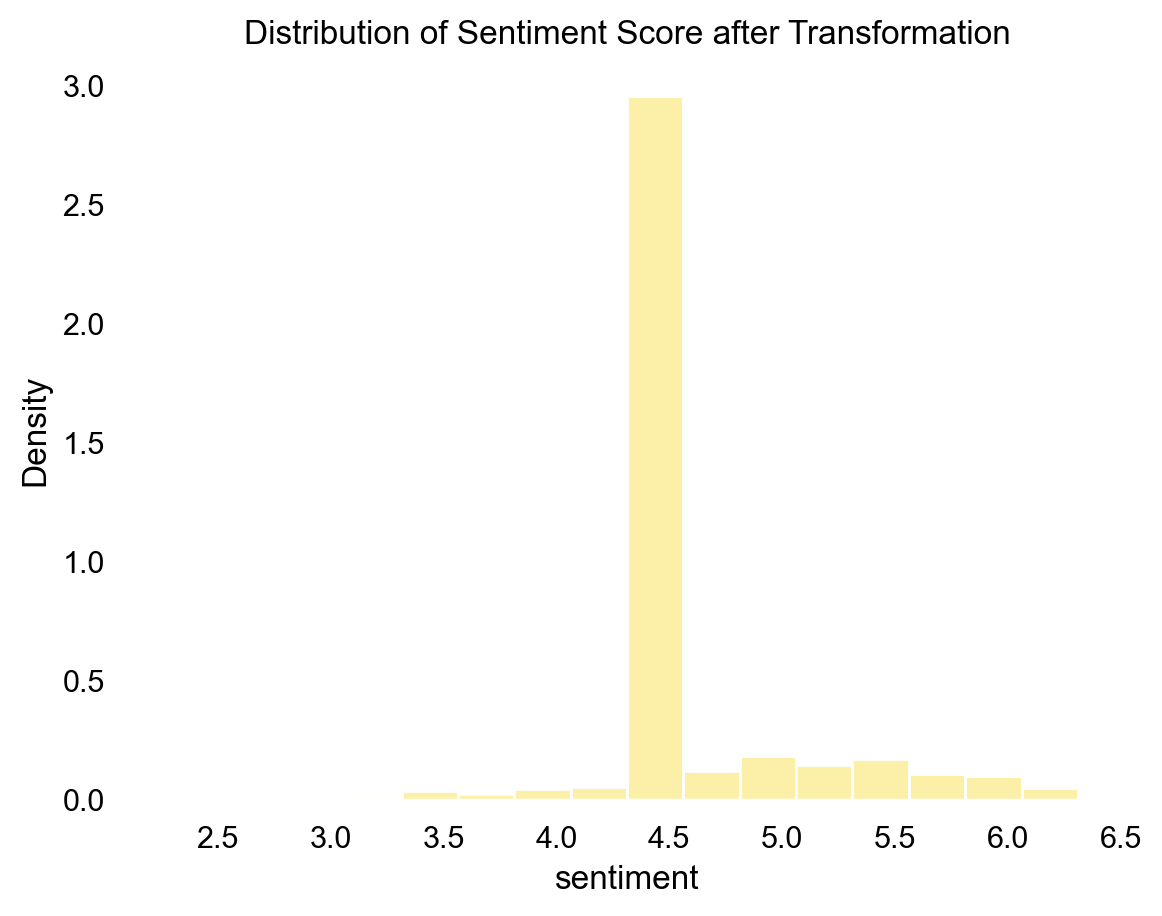

In [54]:
sns.histplot(data=train_df,
             x='sentiment',
             stat='density',
             color='#fcefa7',
            alpha=1.0).set(title='Distribution of Sentiment Score after Transformation')

Here, the skew in the data has been partially mitigated through a specific transformation. Although not entirely eliminated, this tailored approach has been fine-tuned to optimize both the R^2 and MSE scores.

<a id='modeling'></a>

## 6. Modeling

Within this section, we present an overview of six distinct models. 
The following is a sub-chapter contents page detailing the models utilized, culminating in a model summary that juxtaposes the various metric outcomes for each model.:

### Contents (Modelling)
[Scaling](#scaling)<br>
[Train-Test_Split](#train_test_split)<br>
[CountVectorizer - LinearRegression (Baseline Model)](#cv_lr)<br>
[CountVectorizer - RandomForestRegressor](#cv_rfr)<br>
[TfidfVectorizer - LinearRegression](#tv_lr)<br>
[TfidfVectorizer - RandomForestRegressor](#tv_rfr)<br>
[TfidfVectorizer - XGBRegressor](#tv_xgbr)<br>
[Keras (Final Model)](#keras)<br>
[Model Summary](#model_summary)

<a id='scaling'></a>

### Scaling

#### Scale the data to a fixed range of 0 to 1

In [55]:
# scale using minmax
# convert to array
y = train_df['sentiment'].array

mm = MinMaxScaler()
mm.fit(y.reshape(-1,1))
y = mm.transform(y.reshape(-1,1))

# convert back to dataframe
train_df['sentiment'] = pd.DataFrame(y)

<a id='train_test_split'></a>

### Train-Test-Split

#### Using train_test_split, the data will be split for training and testing 

In [56]:
X = train_df['sentence']
y = train_df['sentiment']

In [57]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.78,random_state=42)

print(f'The X train set has {X_train.shape[0]} rows.')
print(f'The y train set has {y_train.shape[0]} rows.')
print(f'The X test set has {X_test.shape[0]} rows.')
print(f'The y test set has {y_test.shape[0]} rows.')

The X train set has 24435 rows.
The y train set has 24435 rows.
The X test set has 6892 rows.
The y test set has 6892 rows.


<a id='cv_lr'></a>

### CountVectorizer - LinearRegression (Baseline Model)

In [58]:
# Fitting the model
pipe_cvec_lr = Pipeline(steps=[('cvec', CountVectorizer()),
                               ('lr', LinearRegression())])

In [59]:
pipe_cvec_lr.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('lr', LinearRegression())])

In [60]:
pipe_cvec_lr.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('lr', LinearRegression())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'lr': LinearRegression(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'lr__copy_X': True,
 'lr__fit_intercept': True,
 'lr__n_jobs': None,
 'lr__positive': False}

In [61]:
# define dictionary of hyperparameters
pipe_cvec_lr_params = {'cvec__max_features':[2000], #2000, 3000, 4000, 5000
                        'cvec__min_df':[2], #2, 3
                        'cvec__max_df':[.90], #.90, .95
                        'cvec__ngram_range':[(1,1)], #(1,1),(1,2),(2,2) 
                       
                       } # 

In [62]:
# instantiate GridSearchCV object
gs_cvec_lr = GridSearchCV(pipe_cvec_lr, 
                          param_grid=pipe_cvec_lr_params, 
                          scoring = 'r2',
                          cv=3)

In [63]:
# fit the GridSearchCV object to data
gs_cvec_lr.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LinearRegression())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [2000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 1)]},
             scoring='r2')

In [64]:
# MSE
print(f'MSE on training set: {mean_squared_error(y_train, (gs_cvec_lr.predict(X_train)), squared=True)}')
print(f'MSE on testing set: {mean_squared_error(y_test, (gs_cvec_lr.predict(X_test)), squared=True)}')

MSE on training set: 0.0030654167446391464
MSE on testing set: 0.005257227465531052


In [65]:
# RMSE - how well a regression model can predict the value of a response variable in absolute terms 
# closer to 0 the better
print(f'RMSE on training set: {mean_squared_error(y_train, (gs_cvec_lr.predict(X_train)), squared=False)}')
print(f'RMSE on testing set: {mean_squared_error(y_test, (gs_cvec_lr.predict(X_test)), squared=False)}')
print(f'RMSE (on training set) over mean y value: {mean_squared_error(y_train, (gs_cvec_lr.predict(X_train)), squared=False)/train_df["sentiment"].mean()}')
print(f'RMSE (on testing set) over mean y value: {mean_squared_error(y_test, (gs_cvec_lr.predict(X_test)), squared=False)/train_df["sentiment"].mean()}')

RMSE on training set: 0.05536620579955923
RMSE on testing set: 0.07250674082822267
RMSE (on training set) over mean y value: 0.09730494298047809
RMSE (on testing set) over mean y value: 0.1274290730257459


In [66]:
print(f'R^2 on training set: {r2_score(y_train, (gs_cvec_lr.predict(X_train)))}')
print(f'R^2 on testing set: {r2_score(y_test, (gs_cvec_lr.predict(X_test)))}')

R^2 on training set: 0.7709634578880796
R^2 on testing set: 0.6283373710812594


In [67]:
# Cross Val Score 
print(f'Cross-Validation Score on training set: {cross_val_score(gs_cvec_lr, X_train, y_train, cv=3).mean()}')
print(f'Cross-Validation Score on testing set: {cross_val_score(gs_cvec_lr, X_test, y_test, cv=3).mean()}')

Cross-Validation Score on training set: 0.5234937766609277
Cross-Validation Score on testing set: -1.1405503800073669


<a id='cv_RFR'></a>

### CountVectorizer - RandomForestRegressor

In [68]:
# Fitting the model
pipe_cvec_rf = Pipeline(steps=[('cvec', CountVectorizer()),
                               ('rf', RandomForestRegressor())])

In [69]:
pipe_cvec_rf.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('rf', RandomForestRegressor())])

In [70]:
pipe_cvec_rf.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('rf', RandomForestRegressor())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'rf': RandomForestRegressor(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'squared_error',
 'rf__max_depth': None,
 'rf__max_features': 1.0,
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_

In [71]:
# define dictionary of hyperparameters
pipe_cvec_rf_params = {'cvec__max_features':[2000], #2000, 3000, 4000, 5000
                        'cvec__min_df':[2], #2, 3
                        'cvec__max_df':[.90], #.90, .95
                        'cvec__ngram_range':[(1,1)], #(1,1),(1,2),(2,2)
                       'rf__max_depth': [None],
                       'rf__max_features': [1.0],
                       'rf__max_leaf_nodes': [None],
                       } # 

In [72]:
# instantiate GridSearchCV object
gs_cvec_rf = GridSearchCV(pipe_cvec_rf, 
                          param_grid=pipe_cvec_rf_params, 
                          scoring = 'r2',
                          cv=3)

In [73]:
# fit the GridSearchCV object to data
gs_cvec_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestRegressor())]),
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [2000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 1)],
                         'rf__max_depth': [None], 'rf__max_features': [1.0],
                         'rf__max_leaf_nodes': [None]},
             scoring='r2')

In [74]:
print(f'MSE on training set: {mean_squared_error(y_train, (gs_cvec_rf.predict(X_train)), squared=True)}')
print(f'MSE on testing set: {mean_squared_error(y_test, (gs_cvec_rf.predict(X_test)), squared=True)}')

MSE on training set: 0.0006004264473896589
MSE on testing set: 0.0027996081569527254


In [75]:
# RMSE - how well a regression model can predict the value of a response variable in absolute terms 
# closer to 0 the better
print(f'RMSE on training set: {mean_squared_error(y_train, (gs_cvec_rf.predict(X_train)), squared=False)}')
print(f'RMSE on testing set: {mean_squared_error(y_test, (gs_cvec_rf.predict(X_test)), squared=False)}')
print(f'RMSE (on training set) over mean y value: {mean_squared_error(y_train, (gs_cvec_rf.predict(X_train)), squared=False)/train_df["sentiment"].mean()}')
print(f'RMSE (on testing set) over mean y value: {mean_squared_error(y_test, (gs_cvec_rf.predict(X_test)), squared=False)/train_df["sentiment"].mean()}')

RMSE on training set: 0.024503600702542858
RMSE on testing set: 0.05291132352297309
RMSE (on training set) over mean y value: 0.04306456320682746
RMSE (on testing set) over mean y value: 0.09299053897721692


In [76]:
print(f'R^2 on training set: {r2_score(y_train, (gs_cvec_rf.predict(X_train)))}')
print(f'R^2 on testing set: {r2_score(y_test, (gs_cvec_rf.predict(X_test)))}')

R^2 on training set: 0.955138368202898
R^2 on testing set: 0.8020801393172562


In [77]:
# Cross Val Score 
print(f'Cross-Validation Score on training set: {cross_val_score(gs_cvec_rf, X_train, y_train, cv=3).mean()}')
print(f'Cross-Validation Score on testing set: {cross_val_score(gs_cvec_rf, X_test, y_test, cv=3).mean()}')

Cross-Validation Score on training set: 0.8052040900497007
Cross-Validation Score on testing set: 0.7390687139119527


<a id='tv_lr'></a>

### TfidfVectorizer - LinearRegression

In [78]:
# Fitting the model
pipe_tvec_lr = Pipeline(steps=[('tvec', TfidfVectorizer()),
                               ('lr', LinearRegression())])

In [79]:
pipe_tvec_lr.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer()), ('lr', LinearRegression())])

In [80]:
pipe_tvec_lr.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('lr', LinearRegression())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'lr': LinearRegression(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'lr__copy_X': True,
 'lr__fit_intercept': True,
 'lr__n_jobs': None,
 'lr__positive': False}

In [81]:
# define dictionary of hyperparameters
pipe_tvec_lr_params = {'tvec__max_features':[4000], #2000, 3000, 4000, 5000
                        'tvec__min_df':[3], #2, 3
                        'tvec__max_df':[.90], #.90, .95
                        'tvec__ngram_range':[(1,2)], #(1,1), (1,2), (2,2) # 
                       } # 

In [82]:
# instantiate GridSearchCV object
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, 
                          param_grid=pipe_tvec_lr_params, 
                          scoring = 'r2',
                          cv=3)

In [83]:
# fit the GridSearchCV object to data
gs_tvec_lr.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LinearRegression())]),
             param_grid={'tvec__max_df': [0.9], 'tvec__max_features': [4000],
                         'tvec__min_df': [3], 'tvec__ngram_range': [(1, 2)]},
             scoring='r2')

In [84]:
print(f'MSE on training set: {mean_squared_error(y_train, (gs_tvec_lr.predict(X_train)), squared=True)}')
print(f'MSE on testing set: {mean_squared_error(y_test, (gs_tvec_lr.predict(X_test)), squared=True)}')

MSE on training set: 0.0020922613749648307
MSE on testing set: 0.0037256088338504367


In [85]:
# RMSE - how well a regression model can predict the value of a response variable in absolute terms 
# closer to 0 the better
print(f'RMSE on training set: {mean_squared_error(y_train, (gs_tvec_lr.predict(X_train)), squared=False)}')
print(f'RMSE on testing set: {mean_squared_error(y_test, (gs_tvec_lr.predict(X_test)), squared=False)}')
print(f'RMSE (on training set) over mean y value: {mean_squared_error(y_train, (gs_tvec_lr.predict(X_train)), squared=False)/train_df["sentiment"].mean()}')
print(f'RMSE (on testing set) over mean y value: {mean_squared_error(y_test, (gs_tvec_lr.predict(X_test)), squared=False)/train_df["sentiment"].mean()}')

RMSE on training set: 0.04574124369718024
RMSE on testing set: 0.0610377656361243
RMSE (on training set) over mean y value: 0.08038927438740455
RMSE (on testing set) over mean y value: 0.10727259018580143


In [86]:
print(f'R^2 on training set: {r2_score(y_train, (gs_tvec_lr.predict(X_train)))}')
print(f'R^2 on testing set: {r2_score(y_test, (gs_tvec_lr.predict(X_test)))}')

R^2 on training set: 0.8436740089730645
R^2 on testing set: 0.7366160048066579


In [87]:
# Cross Val Score 
print(f'Cross-Validation Score on training set: {cross_val_score(gs_tvec_lr, X_train, y_train, cv=3).mean()}')
print(f'Cross-Validation Score on testing set: {cross_val_score(gs_tvec_lr, X_test, y_test, cv=3).mean()}')

Cross-Validation Score on training set: 0.5969766912056796
Cross-Validation Score on testing set: -0.6644587564337718


<a id='tv_rfr'></a>

### TfidfVectorizer - RandomForestRegressor

In [88]:
# Fitting the model
pipe_tvec_rf = Pipeline(steps=[('tvec', TfidfVectorizer()),
                               ('rf', RandomForestRegressor())])

In [89]:
pipe_tvec_rf.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer()), ('rf', RandomForestRegressor())])

In [90]:
pipe_tvec_rf.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('rf', RandomForestRegressor())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'rf': RandomForestRegressor(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'squared_error',
 'rf__max_depth': None,
 'rf__max_features': 1.0,
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 

In [91]:
# define dictionary of hyperparameters
pipe_tvec_rf_params = {'tvec__max_features':[4000], #2000, 3000, 4000, 5000
                        'tvec__min_df':[3], #2, 3
                        'tvec__max_df':[.90], #.90, .95
                        'tvec__ngram_range':[(1,2)], #(1,1),(1,2),(2,2)
                       'rf__max_depth': [None],
                       'rf__max_features': [1.0],
                       'rf__max_leaf_nodes': [None], 
                       } # 

In [92]:
# instantiate GridSearchCV object
gs_tvec_rf = GridSearchCV(pipe_tvec_rf, 
                          param_grid=pipe_tvec_rf_params, 
                          scoring = 'r2',
                          cv=3)

In [93]:
# fit the GridSearchCV object to data
gs_tvec_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestRegressor())]),
             param_grid={'rf__max_depth': [None], 'rf__max_features': [1.0],
                         'rf__max_leaf_nodes': [None], 'tvec__max_df': [0.9],
                         'tvec__max_features': [4000], 'tvec__min_df': [3],
                         'tvec__ngram_range': [(1, 2)]},
             scoring='r2')

In [128]:
print(f'MSE on training set: {mean_squared_error(y_train, (gs_tvec_rf.predict(X_train)), squared=True)}')
print(f'MSE on testing set: {mean_squared_error(y_test, (gs_tvec_rf.predict(X_test)), squared=True)}')

MSE on training set: 0.0005312815388913201
MSE on testing set: 0.002487653098890035


In [94]:
# RMSE - how well a regression model can predict the value of a response variable in absolute terms 
# closer to 0 the better
print(f'RMSE on training set: {mean_squared_error(y_train, (gs_tvec_rf.predict(X_train)), squared=False)}')
print(f'RMSE on testing set: {mean_squared_error(y_test, (gs_tvec_rf.predict(X_test)), squared=False)}')
print(f'RMSE (on training set) over mean y value: {mean_squared_error(y_train, (gs_tvec_rf.predict(X_train)), squared=False)/train_df["sentiment"].mean()}')
print(f'RMSE (on testing set) over mean y value: {mean_squared_error(y_test, (gs_tvec_rf.predict(X_test)), squared=False)/train_df["sentiment"].mean()}')

RMSE on training set: 0.023049545307691433
RMSE on testing set: 0.04987637816532025
RMSE (on training set) over mean y value: 0.0405090914123777
RMSE (on testing set) over mean y value: 0.08765668630101225


In [95]:
print(f'R^2 on training set: {r2_score(y_train, (gs_tvec_rf.predict(X_train)))}')
print(f'R^2 on testing set: {r2_score(y_test, (gs_tvec_rf.predict(X_test)))}')

R^2 on training set: 0.9603046186890024
R^2 on testing set: 0.8241339762007182


In [96]:
# Cross Val Score 
print(f'Cross-Validation Score on training set: {cross_val_score(gs_tvec_rf, X_train, y_train, cv=3).mean()}')
print(f'Cross-Validation Score on testing set: {cross_val_score(gs_tvec_rf, X_test, y_test, cv=3).mean()}')

Cross-Validation Score on training set: 0.816925581595601
Cross-Validation Score on testing set: 0.7184447346346943


<a id='tv_xgbr'></a>

### TfidfVectorizer - XGBRegressor

In [97]:
# Fitting the model
pipe_tvec_xgb = Pipeline(steps=[('tvec', TfidfVectorizer()),
                               ('xgb', xgb.XGBRegressor())])

In [98]:
pipe_tvec_xgb.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer()),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [99]:
pipe_tvec_xgb.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()),
  ('xgb',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=None, ...))],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, col

In [100]:
# define dictionary of hyperparameters
pipe_tvec_xgb_params = { 'tvec__max_features':[4000], #2000, 3000, 4000, 5000
                        'tvec__min_df':[3], #2, 3
                        'tvec__max_df':[.90], #.90, .95
                        'tvec__ngram_range':[(1,2)], #(1,1),(1,2),(2,2)
                       'xgb__n_estimators': [100,200],
                       } # 

In [101]:
# instantiate GridSearchCV object
gs_tvec_xgb = GridSearchCV(pipe_tvec_xgb, 
                          param_grid=pipe_tvec_xgb_params, 
                          scoring = 'r2',
                          cv=3)

In [102]:
# fit the GridSearchCV object to data
gs_tvec_xgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                     importance_type=None...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             param_grid={'tvec__max_df': [0.9], 'tvec__max_features': [4000],
                         'tvec__min_df': [3], 'tvec__ngram_range': [(1, 2)],
                         'xgb__n_estimators': [100, 200]},
             scoring='r2')

In [103]:
print(f'MSE on training set: {mean_squared_error(y_train, (gs_tvec_xgb.predict(X_train)), squared=True)}')
print(f'MSE on testing set: {mean_squared_error(y_test, (gs_tvec_xgb.predict(X_test)), squared=True)}')

MSE on training set: 0.0010858002810774329
MSE on testing set: 0.0028238293460882058


In [104]:
# RMSE - how well a regression model can predict the value of a response variable in absolute terms 
# closer to 0 the better
print(f'RMSE on training set: {mean_squared_error(y_train, (gs_tvec_xgb.predict(X_train)), squared=False)}')
print(f'RMSE on testing set: {mean_squared_error(y_test, (gs_tvec_xgb.predict(X_test)), squared=False)}')
print(f'RMSE (on training set) over mean y value: {mean_squared_error(y_train, (gs_tvec_xgb.predict(X_train)), squared=False)/train_df["sentiment"].mean()}')
print(f'RMSE (on testing set) over mean y value: {mean_squared_error(y_test, (gs_tvec_xgb.predict(X_test)), squared=False)/train_df["sentiment"].mean()}')

RMSE on training set: 0.032951483746220485
RMSE on testing set: 0.05313971533691356
RMSE (on training set) over mean y value: 0.0579115400946196
RMSE (on testing set) over mean y value: 0.09339193278977363


In [105]:
print(f'R^2 on training set: {r2_score(y_train, (gs_tvec_xgb.predict(X_train)))}')
print(f'R^2 on testing set: {r2_score(y_test, (gs_tvec_xgb.predict(X_test)))}')

R^2 on training set: 0.9188730399424365
R^2 on testing set: 0.8003678088372355


In [106]:
# Cross Val Score 
print(f'Cross-Validation Score on training set: {cross_val_score(gs_tvec_xgb, X_train, y_train, cv=3).mean()}')
print(f'Cross-Validation Score on testing set: {cross_val_score(gs_tvec_xgb, X_test, y_test, cv=3).mean()}')

Cross-Validation Score on training set: 0.7890559032433138
Cross-Validation Score on testing set: 0.694719052513744


<a id='keras'></a>

### Keras (Final Model)

#### Kickstart the modeling process by fixing the random seed

In [107]:
tf.keras.utils.set_random_seed(1) 

#### Instantiate variables that will be used in the model. Some of these variables are tuned to optimize for R^2 and MSE scores.

In [108]:
vocab_size = 9800
oov_token = "<OOV>"
padding_type = 'post'
trunc_type = 'post'
embedding_dim = 16 # 16
max_length = 200 # 100, 110

#### Define custom function to calculate R^2

In [109]:
# define custom functions to calculate R2
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) # sum of squares of residuals
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) # total sum of squares
    # K.epsilon: Epsilon is small value that makes very little difference to the value of 
    # the denominator, but ensures that it isn't equal to exactly zero.
    r2_score = (1 - (SS_res / (SS_tot + K.epsilon())))
    return r2_score

#### Initialize and fit the tokenizer

In [110]:
# initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_token)

# create tokens for every word in the corpus
tokenizer.fit_on_texts(X_train)

# save them in word_index
word_index = tokenizer.word_index

#### Turn sentences in both X_train and X_test into sequences of tokens and pad them

In [111]:
# turn sentences into sequences of tokens
X_train_seq = tokenizer.texts_to_sequences(X_train)
# pad sentences so they are all the same length
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=max_length,
                                   padding=padding_type,truncating=trunc_type)

# do the same for X_test
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=max_length,
                                   padding=padding_type,truncating=trunc_type)

#### Build Model

In [112]:
model = tf.keras.Sequential([
    # top layer is an embedding, where direction of each word will be learned epoch by epoch
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # we pool with a global average pooling, ie, adding up the vectors to get meaning
    tf.keras.layers.GlobalAveragePooling1D(),
    # this is then fed into deep neural network
    tf.keras.layers.Dense(96, 
                          activation='relu',
                          kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., 
                                                                                  stddev=2.)),
    tf.keras.layers.Dense(64, 
                          activation='relu'),
    tf.keras.layers.Dense(32, 
                          activation='relu'),
    tf.keras.layers.Dense(1)
])

#### Get model summary

In [113]:
# get model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           156800    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 96)                1632      
                                                                 
 dense_1 (Dense)             (None, 64)                6208      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                        

#### Compile the model

In [114]:
# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0009, 
                                     weight_decay=0.004,
                                     clipvalue=2.)

model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mse',
                       tf.keras.metrics.RootMeanSquaredError(name='RMSE'),
                       R2]) # r2 defined above

#### Fit the model

In [115]:
# fit RNN model
num_epochs = 92 # 550
batch_size = 32

history = model.fit(X_train_seq_padded,y_train,epochs=num_epochs,batch_size=batch_size,
                   validation_data=(X_test_seq_padded, y_test),
                   verbose=2)

Epoch 1/92
764/764 - 2s - loss: 0.0125 - mse: 0.0125 - RMSE: 0.1117 - R2: 0.0276 - val_loss: 0.0084 - val_mse: 0.0084 - val_RMSE: 0.0916 - val_R2: 0.3870 - 2s/epoch - 2ms/step
Epoch 2/92
764/764 - 1s - loss: 0.0045 - mse: 0.0045 - RMSE: 0.0670 - R2: 0.6359 - val_loss: 0.0038 - val_mse: 0.0038 - val_RMSE: 0.0614 - val_R2: 0.7153 - 1s/epoch - 1ms/step
Epoch 3/92
764/764 - 1s - loss: 0.0027 - mse: 0.0027 - RMSE: 0.0516 - R2: 0.7679 - val_loss: 0.0030 - val_mse: 0.0030 - val_RMSE: 0.0546 - val_R2: 0.7699 - 1s/epoch - 2ms/step
Epoch 4/92
764/764 - 1s - loss: 0.0020 - mse: 0.0020 - RMSE: 0.0444 - R2: 0.8321 - val_loss: 0.0029 - val_mse: 0.0029 - val_RMSE: 0.0536 - val_R2: 0.7739 - 1s/epoch - 2ms/step
Epoch 5/92
764/764 - 1s - loss: 0.0016 - mse: 0.0016 - RMSE: 0.0395 - R2: 0.8621 - val_loss: 0.0025 - val_mse: 0.0025 - val_RMSE: 0.0500 - val_R2: 0.8022 - 1s/epoch - 1ms/step
Epoch 6/92
764/764 - 1s - loss: 0.0013 - mse: 0.0013 - RMSE: 0.0361 - R2: 0.8839 - val_loss: 0.0024 - val_mse: 0.0024 - 

Epoch 46/92
764/764 - 1s - loss: 1.7127e-04 - mse: 1.7127e-04 - RMSE: 0.0131 - R2: -8.6666e-01 - val_loss: 0.0012 - val_mse: 0.0012 - val_RMSE: 0.0348 - val_R2: 0.9034 - 1s/epoch - 2ms/step
Epoch 47/92
764/764 - 1s - loss: 2.0505e-04 - mse: 2.0505e-04 - RMSE: 0.0143 - R2: 0.9811 - val_loss: 0.0013 - val_mse: 0.0013 - val_RMSE: 0.0366 - val_R2: 0.8942 - 1s/epoch - 2ms/step
Epoch 48/92
764/764 - 1s - loss: 2.0225e-04 - mse: 2.0225e-04 - RMSE: 0.0142 - R2: 0.9829 - val_loss: 0.0020 - val_mse: 0.0020 - val_RMSE: 0.0447 - val_R2: 0.8486 - 1s/epoch - 2ms/step
Epoch 49/92
764/764 - 1s - loss: 2.0790e-04 - mse: 2.0790e-04 - RMSE: 0.0144 - R2: 0.9818 - val_loss: 0.0012 - val_mse: 0.0012 - val_RMSE: 0.0350 - val_R2: 0.9054 - 1s/epoch - 2ms/step
Epoch 50/92
764/764 - 1s - loss: 1.7635e-04 - mse: 1.7635e-04 - RMSE: 0.0133 - R2: 0.9832 - val_loss: 0.0012 - val_mse: 0.0012 - val_RMSE: 0.0347 - val_R2: 0.9018 - 1s/epoch - 2ms/step
Epoch 51/92
764/764 - 1s - loss: 1.7717e-04 - mse: 1.7717e-04 - RMSE: 

Epoch 91/92
764/764 - 1s - loss: 1.2306e-04 - mse: 1.2306e-04 - RMSE: 0.0111 - R2: 0.9871 - val_loss: 0.0012 - val_mse: 0.0012 - val_RMSE: 0.0347 - val_R2: 0.9002 - 1s/epoch - 2ms/step
Epoch 92/92
764/764 - 1s - loss: 1.1840e-04 - mse: 1.1840e-04 - RMSE: 0.0109 - R2: 0.9897 - val_loss: 0.0012 - val_mse: 0.0012 - val_RMSE: 0.0339 - val_R2: 0.9110 - 1s/epoch - 2ms/step


#### Save the training history into a dataframe

In [116]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.rename(columns={'mse': 'MSE','val_mse': 'val_MSE'})
hist.tail()

,loss,MSE,RMSE,R2,val_loss,val_MSE,val_RMSE,val_R2,epoch
87,0.000159,0.000159,0.012601,0.987198,0.001190,0.001190,0.034500,0.902072,87
88,0.000109,0.000109,0.010459,0.989663,0.001186,0.001186,0.034441,0.905564,88
89,0.000104,0.000104,0.010217,0.990842,0.001173,0.001173,0.034251,0.906260,89
90,0.000123,0.000123,0.011093,0.987078,0.001202,0.001202,0.034665,0.900228,90
91,0.000118,0.000118,0.010881,0.989671,0.001152,0.001152,0.033944,0.910970,91


#### Visualize MSE progress

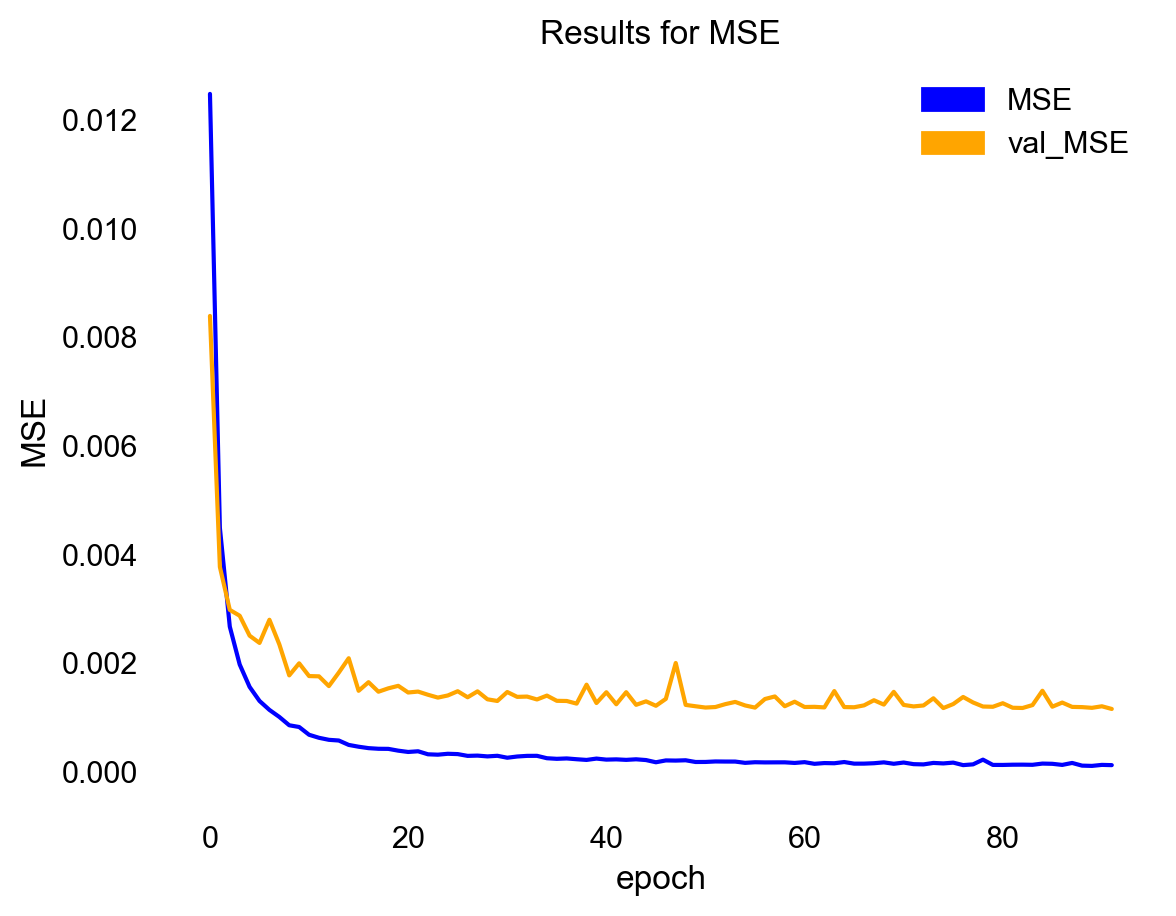

In [118]:
metric = 'MSE'
sns.lineplot(data=hist,x='epoch',y=metric,color='blue').set(title=f'Results for {metric}')
metric_patch = mpatches.Patch(color='blue', label=metric)
sns.lineplot(data=hist,x='epoch',y=f'val_{metric}',color='orange')
val_metric_patch = mpatches.Patch(color='orange', label=f'val_{metric}')

plt.legend(handles=[metric_patch,val_metric_patch],
           labels=[metric,f'val_{metric}'],
          frameon=False)

#### Visualize RMSE progress

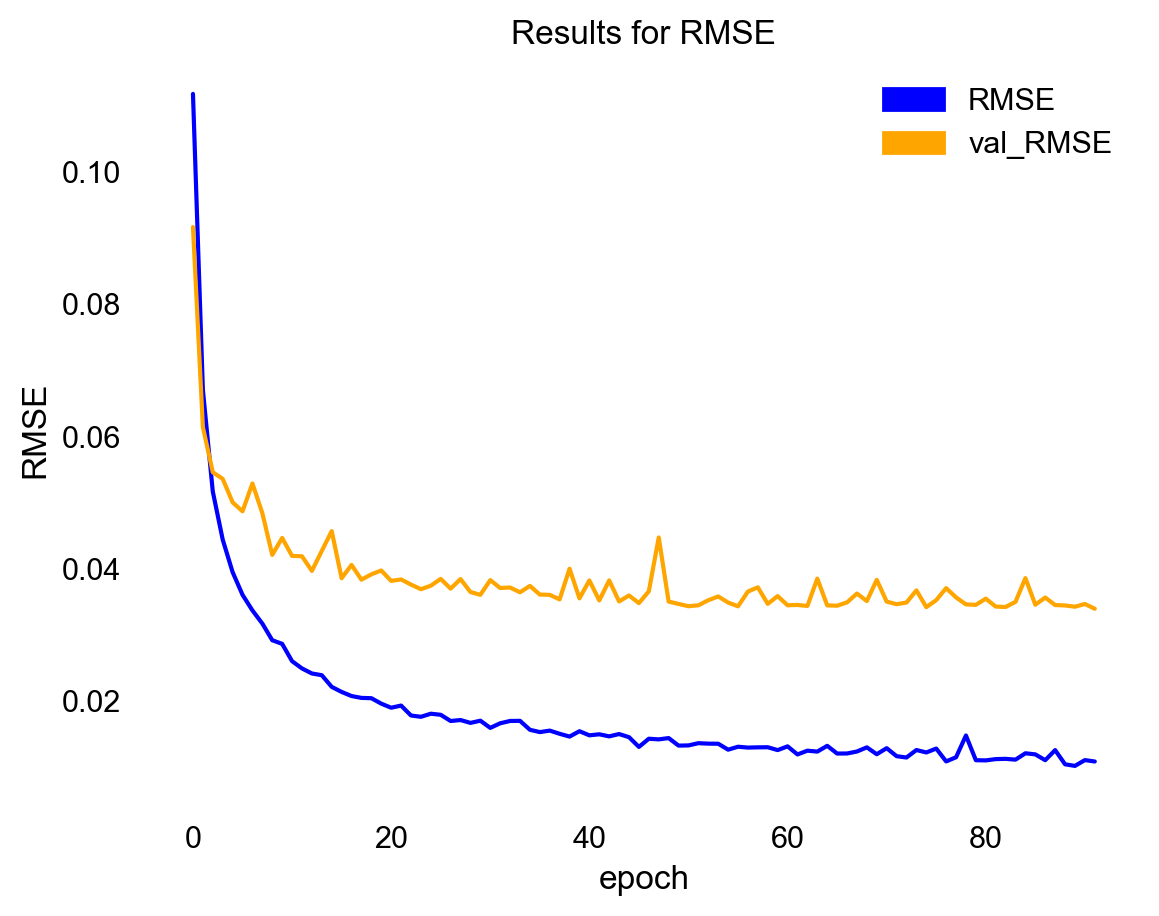

In [119]:
metric = 'RMSE'
sns.lineplot(data=hist,x='epoch',y=metric,color='blue').set(title=f'Results for {metric}')
metric_patch = mpatches.Patch(color='blue', label=metric)
sns.lineplot(data=hist,x='epoch',y=f'val_{metric}',color='orange')
val_metric_patch = mpatches.Patch(color='orange', label=f'val_{metric}')

plt.legend(handles=[metric_patch,val_metric_patch],
           labels=[metric,f'val_{metric}'],
          frameon=False)

#### Visualize R^2 progress

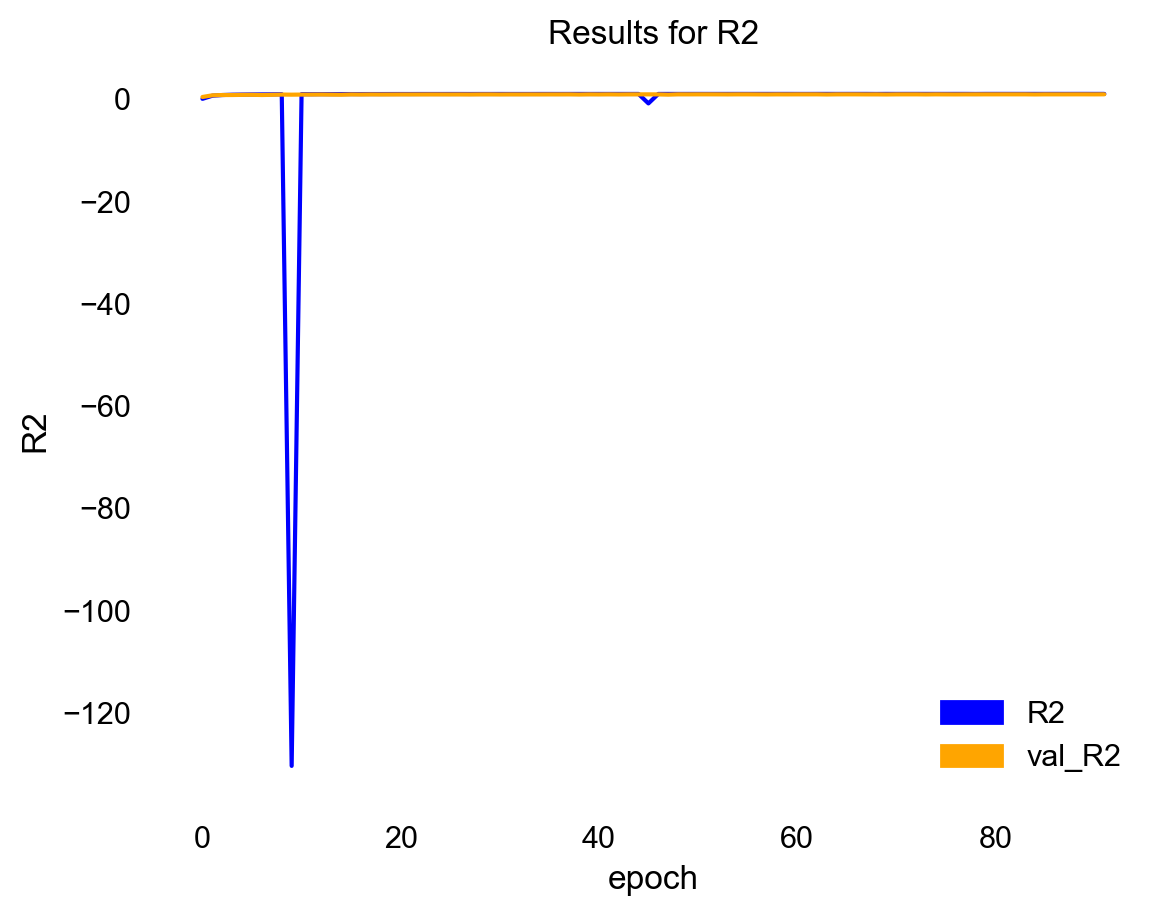

In [120]:
metric = 'R2'
sns.lineplot(data=hist,x='epoch',y=metric,color='blue').set(title=f'Results for {metric}')
metric_patch = mpatches.Patch(color='blue', label=metric)
sns.lineplot(data=hist,x='epoch',y=f'val_{metric}',color='orange')
val_metric_patch = mpatches.Patch(color='orange', label=f'val_{metric}')

plt.legend(handles=[metric_patch,val_metric_patch],
           labels=[metric,f'val_{metric}'],
          frameon=False)

<a id='model_summary'></a>

### Model Summary

|Model|Train MSE Score|Test MSE Score|Train RMSE Score|Test RMSE Score|Train R2 Score|Test R2 Score|
|:-|:-:|:-:|:-:|:-:|:-:|:-:|
|<b>CountVectorizer - LinearRegression (Baseline)</b>|<b>0.0031</b>|<b>0.0053</b>|<b>0.055</b>|<b>0.073</b>|<b>0.77</b>|<b>0.63</b>|
|CountVectorizer - RandomForestRegressor|0.0006|0.0028|0.025|0.053|0.96|0.80|
|TfidfVectorizer - LinearRegression|0.0021|0.0037|0.046|0.061|0.84|0.74|
|TfidfVectorizer - RandomForestRegressor|0.0005|0.0025|0.023|0.050|0.96|0.82|
|TfidfVectorizer - XGBRegressor|0.0011|0.0028|0.033|0.053|0.92|0.80|
|<b>Keras (Final Model)</b>|<b>0.0001</b>|<b>0.0012</b>|<b>0.011</b>|<b>0.034</b>|<b>0.99</b>|<b>0.91</b>|


The final model demonstrated noteworthy enhancements across all metrics. Against the baseline model, the final model's Test MSE Score improved by 77.4%, while the Test RMSE Score improved by 53.4%, and finally, the Test R^2 Score improved by 44.4%. 

Additionally, it is pertinent to highlight that the ultimate model's performance surpasses that of all other models, exhibiting superiority across all metrics, not solely in comparison to the baseline model.

#### Save the final trained model

In [36]:
# https://www.tensorflow.org/guide/keras/serialization_and_saving
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
model.save("keras_model_k.h5")

In [37]:
# It can be used to reconstruct the model identically.
reconstructed_model = tf.keras.models.load_model("keras_model_k.h5", custom_objects={"R2": R2 })

In [29]:
# Let's check:
np.testing.assert_allclose(
    model.predict(X_test_seq_padded), reconstructed_model.predict(X_test_seq_padded)
)

216/216 [==============================] - 0s 454us/step


In [32]:
pred = model.predict(X_test_seq_padded)

216/216 [==============================] - 0s 452us/step


In [33]:
pred

array([[0.53233874],
       [0.53300905],
       [0.53140783],
       ...,
       [0.5321098 ],
       [0.6403018 ],
       [0.53173107]], dtype=float32)

In [30]:
recon_pred = reconstructed_model.predict(X_test_seq_padded)

216/216 [==============================] - 0s 449us/step


In [31]:
recon_pred

array([[0.53233874],
       [0.53300905],
       [0.53140783],
       ...,
       [0.5321098 ],
       [0.6403018 ],
       [0.53173107]], dtype=float32)

#### Reverse both the transformation and scaling

In [122]:
len(pred)

6892

<a id='insights'></a>

## 7. Insights

- Based on our model’s feature importance, we can predict areas of importance to prioritise efforts on spray deployment. 
- The agency should consider the following collectively to determine priority areas within Chicago: 
    - `Month`, specifically in the months of Aug as we have seen in our EDA. 
    - a higher `roll_mean_28_Tavg`, as a higher 28day mean temperature in the summer months are optimal for mosquito gestation and activity, which would increase likelihood of WNV+ trap locations in those with `species` of `Culex Pipiens`.  
    - the `sunset`, `sunrise` and `timediff` (i.e. length of night) also prove to be important in predicting WNV+ as it is likely that `Culex Pipiens` favour around 11-12 hours of night time for their 'munching' activities. That said, the optimal length of night from a relatively late sunrise and sunset also tends to occur in Aug.  
    - as `trap` is feature engineered indirectly with `WnvPresent` and the same trap is usually deployed at the same locations, it is no surprise that this is an important feature. This also means that the model is dependent on how `trap` ID is assigned currently.

- Next, we also saw from our EDA of spray dataset that spray effectiveness is somewhat weak. Through use of our model's predictions, we would be able to augment spray deployments and optimise its use effectively. 

<a id='biz_rec'></a>

## 8. Recommendations

Instead of the current approach (i.e. as of 2015 when the Kaggle competition was launched by CDPH) where the agency seems to deploy adulticide spraying based on positive WNV traps<sup>1</sup>, we urge the agency to consider a data driven approach using our model to predict priority areas ahead of traps turning WNV positive. This also means that instead of spraying after the event where traps turn WNV positive, this model allows the agency to take pre-emptive action before the area is filled with WNV positive mosquitoes, which could have already led to incidence of human WNV cases. From a public health point of view, this would allow us to hammer down on the growth in WNV presence in the area, before the actual spike in human cases. 

Since the model is able to predict probabilities of WNV presence, the agency is able to accord different risk levels to these 77 community areas in Chicago, e.g. RED for highest risk, AMBER for medium risk, GREEN for low risk. Courses of action to take for each risk level can be drawn up, with RED being assigned the highest response measures (e.g. adulticiding + larvaciding + public education/comms campaign). Such information can also be made online for businesses and public to plan ahead. 


<sup>1. https://www.chicago.gov/city/en/depts/cdph/supp_info/infectious/west_nile_virus_surveillancereports.html</sup>

<a id='conclusion'></a>

## 9. Conclusion

Upon revisiting the problem statement, we are reminded of our two primary objectives:

1) <b>Objective 1</b>
- Our first objective was to construct a robust predictive model to facilitate informed decision-making by the city of Chicago regarding the strategic allocation of pesticide spraying for mosquito control.
- With a test ROC AUC of 0.88 and kaggle ROC AUC of 0.76, our model can efficiently predict and classify 76-88% of WNV+ traps correctly. The model can be deployed for early operations planning and decision making on which areas to be sprayed during the summer months. This will help to focus vector control efforts on potential hotspots, and prevent rise in unnecessary cases and deaths, and unnecessary use of financial and manpower resources to deploy the sprays. Nevertheless, the model would still need to be updated with up-to-date data so that it can continue to generate accurate predictions for continued future use.

2) <b>Objective 2</b>
- Our second objective was to conduct a comprehensive cost-benefit analysis. 
- Based on a 2013-year scenario cost benefit analysis, we estimate that our model approach outperforms the current approach with a benefit-cost ratio of 353. (if required, please refer to the pdf deck for details) 




## <b> End of Part III</b> <br>
[Part I](Part_1-Data_Collection.ipynb#part_i) <br>
[Part II](Part_2-Prepare_Training_Data.ipynb#part_ii)